In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split, TensorDataset
import random
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Function to distribute the dataset among clients ensuring more variations
def distribute_cifar_varied(cifar_dataset, num_clients=5, common_labels_per_client=None, private_labels_per_client=None):
    num_samples = len(cifar_dataset)

    # Collect all indices for available labels
    all_indices = {i: [] for i in range(num_clients)}
    for idx in range(num_samples):
        _, label = cifar_dataset[idx]  # Assuming cifar_dataset returns (image, label)
        for client_id in range(num_clients):
            common_labels = common_labels_per_client[client_id]
            private_labels = private_labels_per_client[client_id]
            if label in common_labels or label in private_labels:
                all_indices[client_id].append(idx)

    client_data_list = []
    assigned_indices = set()  # Track assigned indices to avoid duplicates

    # Create subsets for each client
    for client_id in range(num_clients):
        # Filter available indices for this client, excluding already assigned indices
        available_indices = [idx for idx in all_indices[client_id] if idx not in assigned_indices]

        # Randomly select a subset from the available indices
        # You can define the number of samples you want for each client here
        num_samples_for_client = min(len(available_indices), 8000)  # Adjust sample size as needed
        selected_indices = torch.randperm(len(available_indices))[:num_samples_for_client].tolist()
        selected_indices = [available_indices[i] for i in selected_indices]

        # Update the assigned indices
        assigned_indices.update(selected_indices)

        # Create a subset for the client based on the selected indices
        client_subset = Subset(cifar_dataset, selected_indices)
        client_data_list.append(client_subset)

    return client_data_list



# Define a wrapper for augmentation
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, transform):
        self.original_dataset = original_dataset
        self.transform = transform

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        image, label = self.original_dataset[idx]
        image = self.transform(image)  # Apply augmentation transform
        return image, label

def prepare_model_datasets(client_data, private_labels, common_labels, train_ratio=0.8):
    images, labels = zip(*client_data)  # Unpacking client data
    images = torch.stack(images)  # Convert list of tensors to a single tensor
    labels = torch.tensor(labels)  # Convert labels to tensor

    # Model 1: Known (common labels or any private_label), unknown (rest treated as anomalies)
    model1_labels = torch.where((torch.isin(labels, torch.tensor(common_labels))) | (torch.isin(labels, torch.tensor(private_labels))), 1, 0)

    # Model 2: Common (0), private (1), drop the rest
    model2_labels = torch.where(torch.isin(labels, torch.tensor(private_labels)), 1, torch.where(torch.isin(labels, torch.tensor(common_labels)), 0, -1))

    # Model 3: Keep only labels in common_labels (drop everything else)
    model3_valid_indices = torch.isin(labels, torch.tensor(common_labels)).nonzero(as_tuple=True)[0]
    model3_images = images[model3_valid_indices]
    model3_labels = labels[model3_valid_indices]
    model3_dataset = TensorDataset(model3_images, model3_labels)

    # Model 4: Create dataset with multiple private labels, remapping labels to range 0 to len(private_labels)-1
    model4_valid_indices = torch.isin(labels, torch.tensor(private_labels)).nonzero(as_tuple=True)[0]
    model4_images = images[model4_valid_indices]
    model4_labels = labels[model4_valid_indices]

    # Map the private labels to a range from 0 to len(private_labels) - 1
    label_mapping = {label: idx for idx, label in enumerate(private_labels)}
    model4_mapped_labels = torch.tensor([label_mapping[label.item()] for label in model4_labels])

    model4_dataset = TensorDataset(model4_images, model4_mapped_labels)

    # Define augmentation transforms (only for the training set of Model 1)
    augmentation_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomResizedCrop(size=(images.shape[2], images.shape[3]), scale=(0.8, 1.0))
    ])

    # Function to split datasets and apply augmentation to training data
    def split_dataset(dataset, train_ratio, apply_augmentation=False):
        train_size = int(len(dataset) * train_ratio)
        test_size = len(dataset) - train_size
        train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
        
        # Apply augmentation only to the training dataset if specified
        if apply_augmentation:
            train_dataset = AugmentedDataset(train_dataset, augmentation_transforms)
        
        return train_dataset, test_dataset

    # Create TensorDataset for each model
    model1_dataset = TensorDataset(images, model1_labels)
    model2_valid_indices = (model2_labels != -1).nonzero(as_tuple=True)[0]
    model2_dataset = TensorDataset(images[model2_valid_indices], model2_labels[model2_valid_indices])

    # Split dataset for Model 1 without augmentation
    model1_train_test = split_dataset(model1_dataset, train_ratio)

    # Split dataset for Model 2 without augmentation
    model2_train_test = split_dataset(model2_dataset, train_ratio)

    # Split dataset for Model 3 with common labels in train set, no augmentation
    model3_train_test = split_dataset(model3_dataset, train_ratio)

    # Generic train-test split for Model 4 with remapped labels, no augmentation
    model4_train_test = split_dataset(model4_dataset, train_ratio)

    return model1_train_test, model2_train_test, model3_train_test, model4_train_test

# Define Deep Convolutional Autoencoder for Model 1 (Anomaly Detection)
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # First layer: 3 input channels for RGB images
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout layer with 20% probability
            nn.MaxPool2d(2, 2),  # Downsample to 16x16
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(2, 2),  # Downsample to 8x8
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(2, 2),  # Downsample to 4x4
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # Upsample to 8x8
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),   # Upsample to 16x16
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),    # Upsample to 32x32
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),  # Final layer with 3 output channels for RGB
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Loss function for autoencoder (MSE loss for reconstruction)
def autoencoder_loss(reconstructed, original):
    return nn.MSELoss()(reconstructed, original)

# Function to determine threshold
def determine_threshold(autoencoder, train_loader, percentile=95):
    autoencoder.eval()
    losses = []
    with torch.no_grad():
        for images, _ in train_loader:
            images = images.to(device)  # Move images to device
            reconstructed = autoencoder(images)
            # Calculate per-image reconstruction loss
            loss = nn.MSELoss(reduction='none')(reconstructed, images)
            loss = loss.mean([1, 2, 3])  # Average over each image
            losses.extend(loss.cpu().numpy())
    # Set threshold based on the chosen percentile
    threshold = np.percentile(losses, percentile)
    print(f"Determined threshold at {percentile}th percentile: {threshold:.4f}")
    return threshold

def train_autoencoder_with_threshold(autoencoder, train_loader, criterion, optimizer, num_epochs=100, percentile=95):
    autoencoder.train()
    train_losses = []  # List to store training losses for each epoch

    for epoch in range(num_epochs):
        epoch_loss = 0.0  # Variable to accumulate loss for the current epoch
        for images, _ in train_loader:
            images = images.to(device)  # Move images to device
            optimizer.zero_grad()  # Clear gradients
            outputs = autoencoder(images)  # Forward pass
            loss = criterion(outputs, images)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            
            epoch_loss += loss.item()  # Accumulate loss
        
        # Average loss for the epoch
        avg_epoch_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_epoch_loss)  # Store the average loss for this epoch
        
        #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')

    # Plotting the training loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
    plt.title('Autoencoder Training Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.grid()
    plt.show()

    # Determine threshold based on reconstruction loss
    threshold = determine_threshold(autoencoder, train_loader, percentile)
    return autoencoder, threshold

# Test function for autoencoder (anomaly detection)
def test_autoencoder(autoencoder, test_loader, threshold):
    autoencoder.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)  # Move images to device
            labels=labels.to(device)
            reconstructed = autoencoder(images)
            loss = nn.MSELoss(reduction='none')(reconstructed, images)
            loss = loss.mean([1, 2, 3])  # Average over each image
            predictions = (loss < threshold).long()  # Anomalies have higher loss, flag them as unknown
            correct += (predictions == labels).sum().item()

    accuracy = correct / len(test_loader.dataset) * 100
    return accuracy

class Model4(nn.Module):
    def __init__(self):
        super(Model4, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),  # Batch normalization
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),  # Batch normalization
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Increased filters
            nn.ReLU(),
            nn.BatchNorm2d(128),  # Batch normalization
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),  # Increased hidden layer size
            nn.ReLU(),
            nn.Dropout(0.5),  # Added dropout for regularization
            nn.Linear(256, 128),  # Additional fully connected layer
            nn.ReLU(),
            nn.Dropout(0.5),  # Added dropout for regularization
            nn.Linear(128, 2)  # Output for 2 private classes (CIFAR-10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        return self.fc(x)

class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),  # Added batch normalization
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),  # Added batch normalization
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Increased filters
            nn.ReLU(),
            nn.BatchNorm2d(128),  # Added batch normalization
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),  # Increased hidden layer size
            nn.ReLU(),
            nn.Dropout(0.5),  # Added dropout for regularization
            nn.Linear(256, 128),  # Additional fully connected layer
            nn.ReLU(),
            nn.Dropout(0.5),  # Added dropout for regularization
            nn.Linear(128, 5)  # Output for 5 common classes (CIFAR-10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        return self.fc(x)

class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),  # Batch normalization
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),  # Batch normalization
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Increased filters
            nn.ReLU(),
            nn.BatchNorm2d(128),  # Batch normalization
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # Additional convolutional layer
            nn.ReLU(),
            nn.BatchNorm2d(256),  # Batch normalization
            nn.MaxPool2d(2, 2),
        )
        self.fc = nn.Sequential(
            nn.Linear(256 * 2 * 2, 512),  # Change to 256 * 2 * 2 = 1024
            nn.ReLU(),
            nn.Dropout(0.5),  # Added dropout for regularization
            nn.Linear(512, 256),  # Additional fully connected layer
            nn.ReLU(),
            nn.Dropout(0.5),  # Added dropout for regularization
            nn.Linear(256, 2)   
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        return self.fc(x)
    
# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=50):
    model.train()
    train_losses = []  # List to store training losses for each epoch
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0  # Variable to accumulate loss for the current epoch
        for images, labels in train_loader:
            images = images.to(device)  # Move images to device
            labels = labels.to(device)  # Move labels to device
            
            optimizer.zero_grad()  # Clear gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            
            epoch_loss += loss.item()  # Accumulate loss
        
        # Average loss for the epoch
        avg_epoch_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_epoch_loss)  # Store the average loss for this epoch
        
        #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')
    
    # Plotting the training loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
    plt.title('Training Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.grid()
    plt.show()

# Testing function
def test_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)  # Move images to device
            labels = labels.to(device)  # Move labels to device
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = correct / len(test_loader.dataset) * 100
    return avg_loss, accuracy

# Federated Averaging Function
def federated_average(models):
    new_params = {}
    for key in models[0].state_dict().keys():
        # Ensure that the parameters are converted to float
        param_tensors = [model.state_dict()[key].to(device).float() for model in models]
        new_params[key] = torch.mean(torch.stack(param_tensors), dim=0)
    return new_params


Files already downloaded and verified


In [19]:
# Prepare dataset for each client
num_clients = 5  # Adjust based on your needs
client_common_labels = [
    [0, 1, 2],  # Client 1
    [1, 2, 3],  # Client 2
    [2, 3, 4],  # Client 3
    [3, 4, 0],  # Client 4
    [4, 0, 1]   # Client 5
]
client_private_labels = [
    [5, 6],  # Client 1
    [7, 8],  # Client 2
    [6, 9],  # Client 3
    [5, 9],  # Client 4
    [7, 8]   # Client 5
]

# Distributing the CIFAR dataset using the varied function
client_data_list = distribute_cifar_varied(cifar10_train, num_clients, client_common_labels, client_private_labels)

# Prepare datasets for all four models for each client
client_datasets = []
for client_id, client_data in enumerate(client_data_list):
    private_labels = client_private_labels[client_id]
    common_labels = client_common_labels[client_id]

    model1_train_test, model2_train_test, model3_train_test, model4_train_test = prepare_model_datasets(client_data, private_labels, common_labels)

    ''''# Move datasets to device
    model1_train_test = model1_train_test.to(device)
    model2_train_test = model2_train_test.to(device)
    model3_train_test = model3_train_test.to(device)
    model4_train_test = model4_train_test.to(device)'''

    client_datasets.append({
        'model1': model1_train_test,
        'model2': model2_train_test,
        'model3': model3_train_test,
        'model4': model4_train_test,
    })

Training for Client 0 with private labels [5, 6] and common labels [0, 1, 2]...
Training Model 1 (Autoencoder) for Client 0...


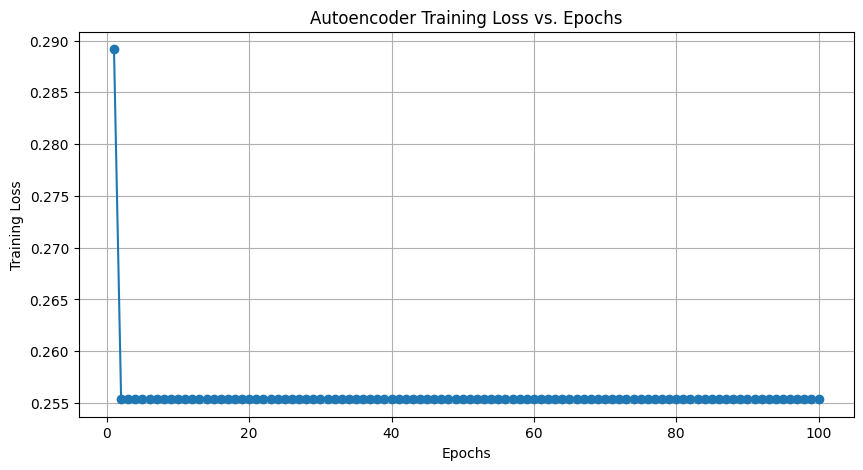

Determined threshold at 95th percentile: 0.5201
Training Model 2 for Client 0...


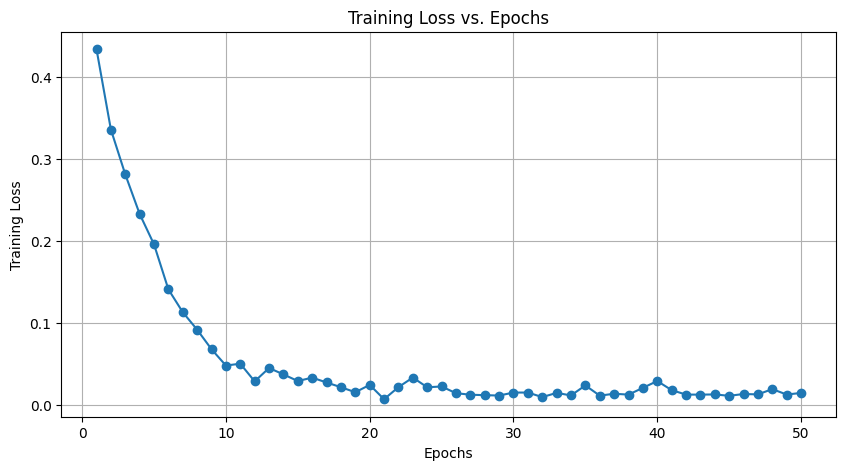

Training Model 4 for Client 0 with labels [5, 6]...


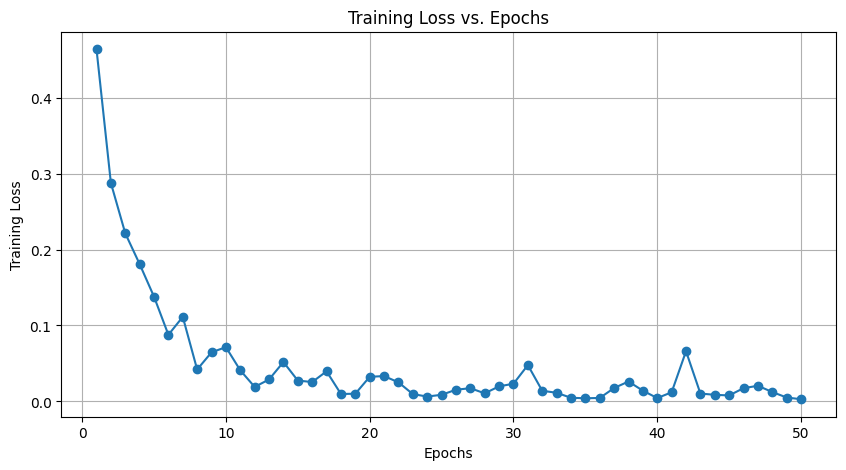

Testing Model 1 (Autoencoder) for Client 0...
Model 1 Test Accuracy: 94.69%
Testing Model 2 for Client 0...
Model 2 Test Loss: 0.7901, Test Accuracy: 89.19%
Testing Model 4 for Client 0...
Model 4 Test Loss: 0.7128, Test Accuracy: 90.82%
Training for Client 1 with private labels [7, 8] and common labels [1, 2, 3]...
Training Model 1 (Autoencoder) for Client 1...


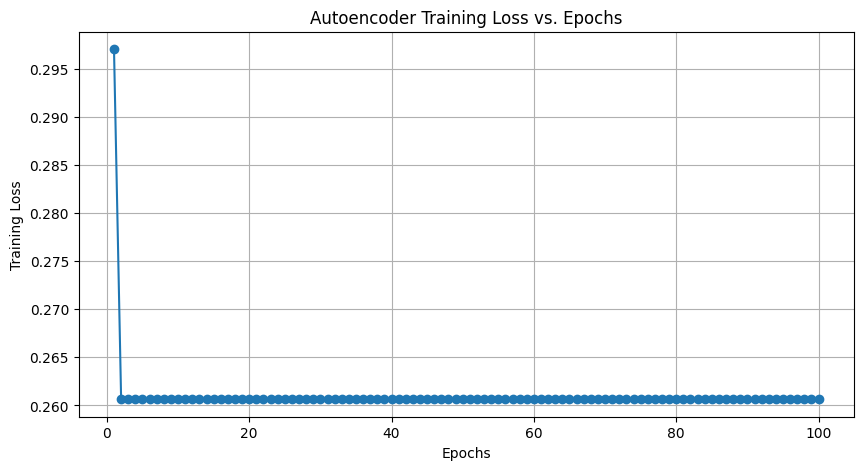

Determined threshold at 95th percentile: 0.5041
Training Model 2 for Client 1...


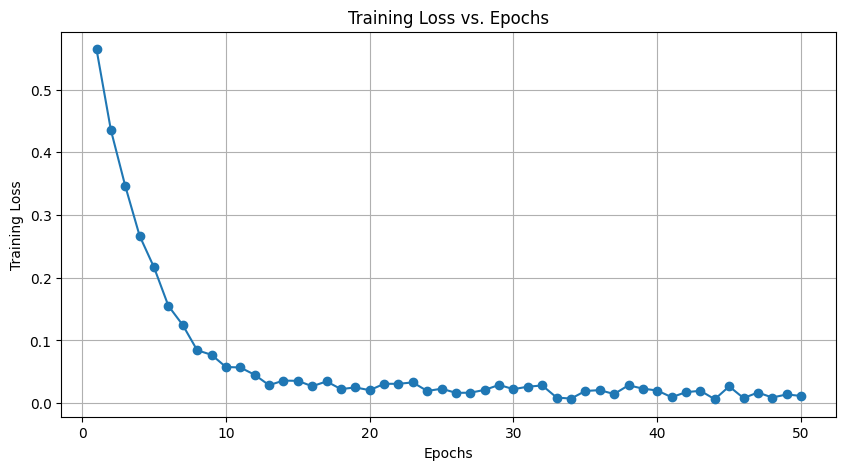

Training Model 4 for Client 1 with labels [7, 8]...


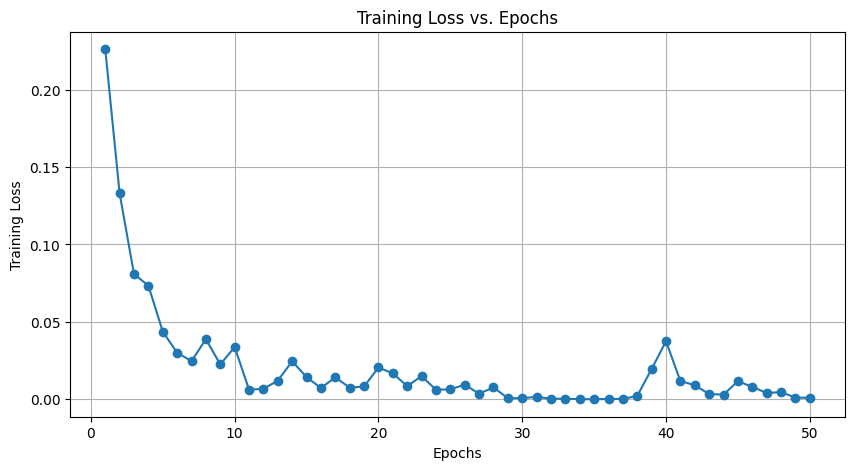

Testing Model 1 (Autoencoder) for Client 1...
Model 1 Test Accuracy: 94.50%
Testing Model 2 for Client 1...
Model 2 Test Loss: 0.8371, Test Accuracy: 88.38%
Testing Model 4 for Client 1...
Model 4 Test Loss: 0.2797, Test Accuracy: 96.43%
Training for Client 2 with private labels [6, 9] and common labels [2, 3, 4]...
Training Model 1 (Autoencoder) for Client 2...


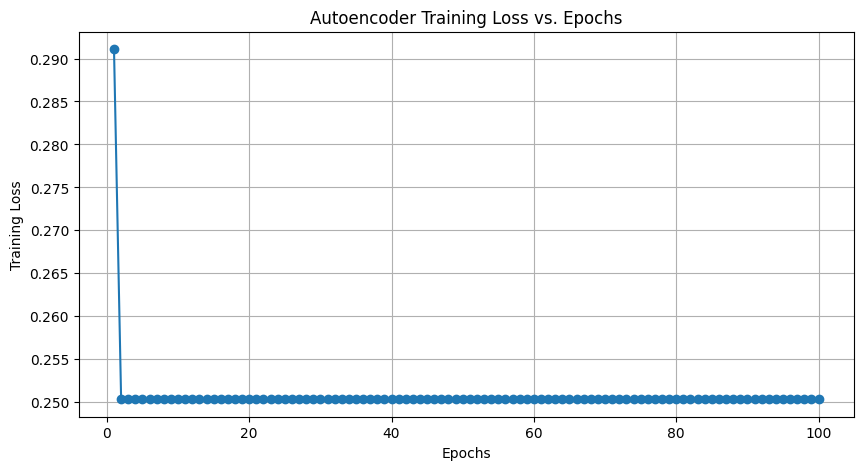

Determined threshold at 95th percentile: 0.4875
Training Model 2 for Client 2...


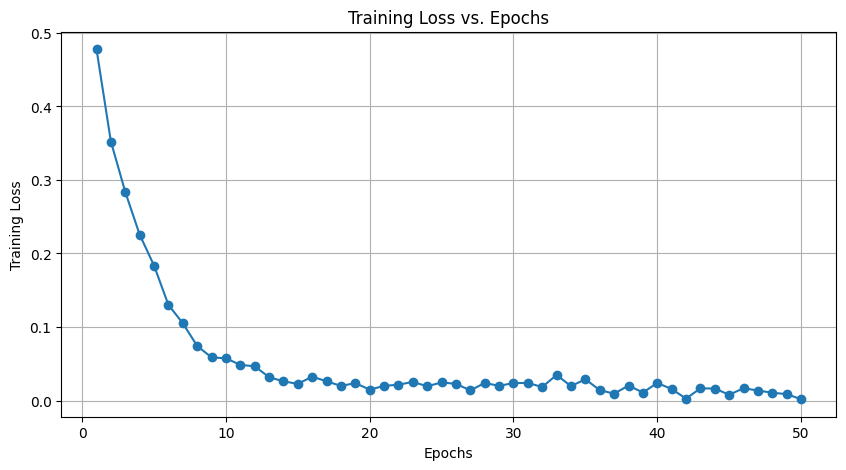

Training Model 4 for Client 2 with labels [6, 9]...


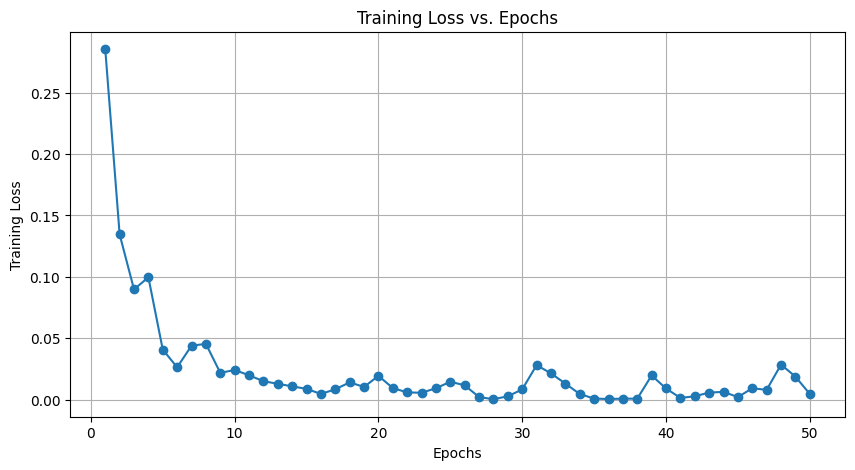

Testing Model 1 (Autoencoder) for Client 2...
Model 1 Test Accuracy: 95.69%
Testing Model 2 for Client 2...
Model 2 Test Loss: 1.1791, Test Accuracy: 87.56%
Testing Model 4 for Client 2...
Model 4 Test Loss: 0.1175, Test Accuracy: 98.24%
Training for Client 3 with private labels [5, 9] and common labels [3, 4, 0]...
Training Model 1 (Autoencoder) for Client 3...


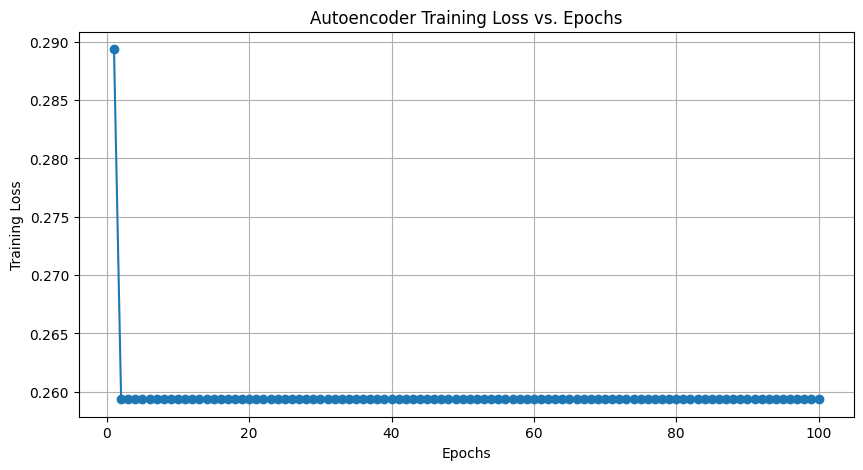

Determined threshold at 95th percentile: 0.5046
Training Model 2 for Client 3...


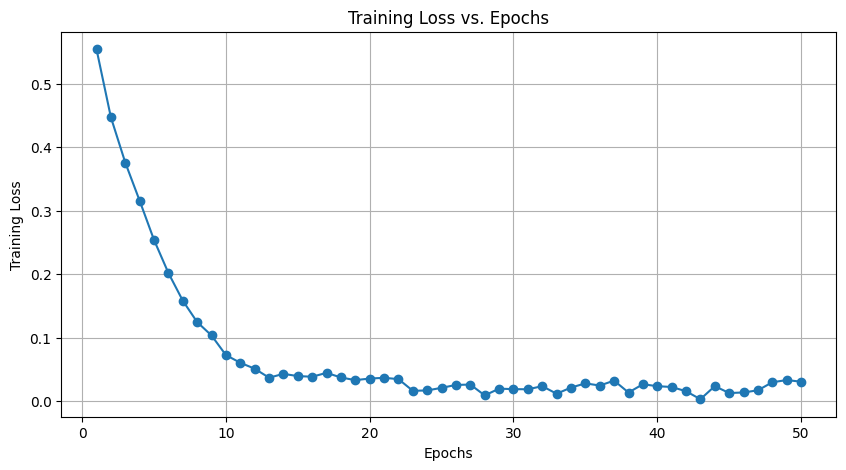

Training Model 4 for Client 3 with labels [5, 9]...


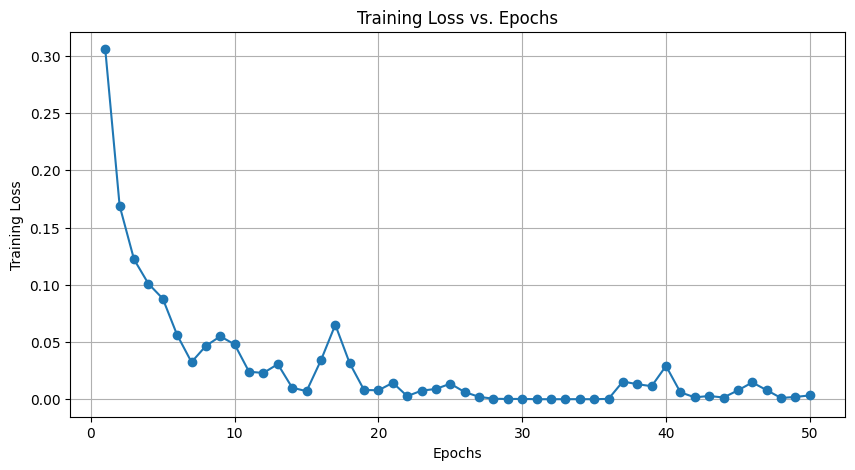

Testing Model 1 (Autoencoder) for Client 3...
Model 1 Test Accuracy: 95.88%
Testing Model 2 for Client 3...
Model 2 Test Loss: 0.8500, Test Accuracy: 83.19%
Testing Model 4 for Client 3...
Model 4 Test Loss: 0.3132, Test Accuracy: 96.38%
Training for Client 4 with private labels [7, 8] and common labels [4, 0, 1]...
Training Model 1 (Autoencoder) for Client 4...


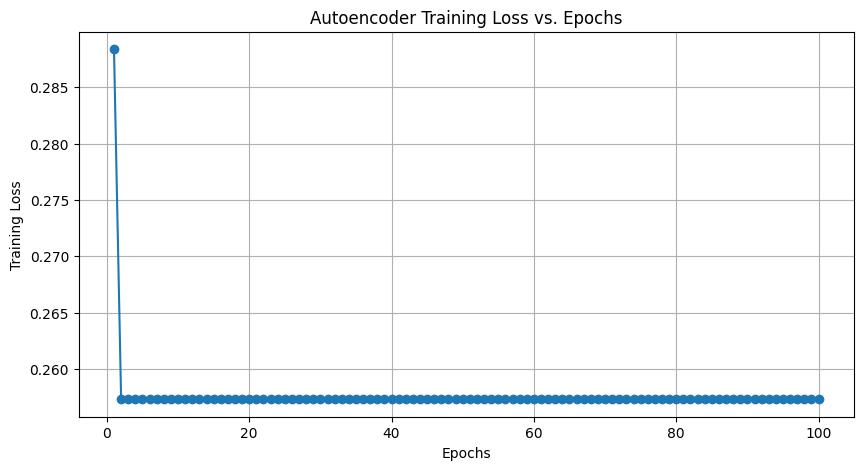

Determined threshold at 95th percentile: 0.4985
Training Model 2 for Client 4...


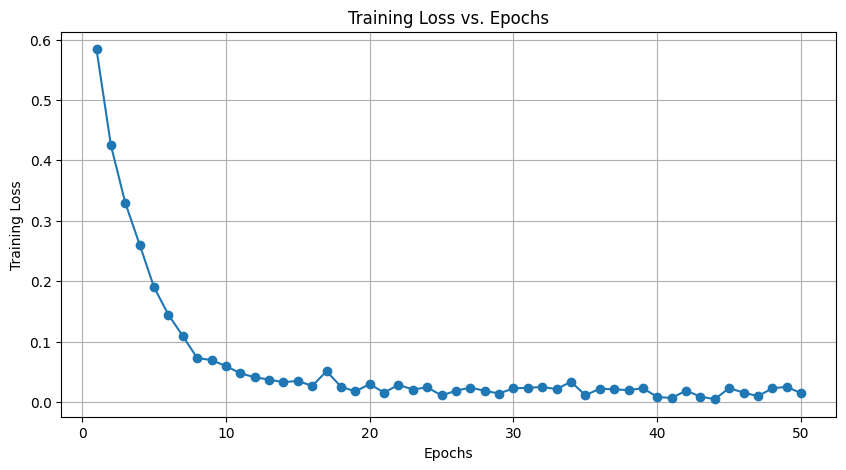

Training Model 4 for Client 4 with labels [7, 8]...


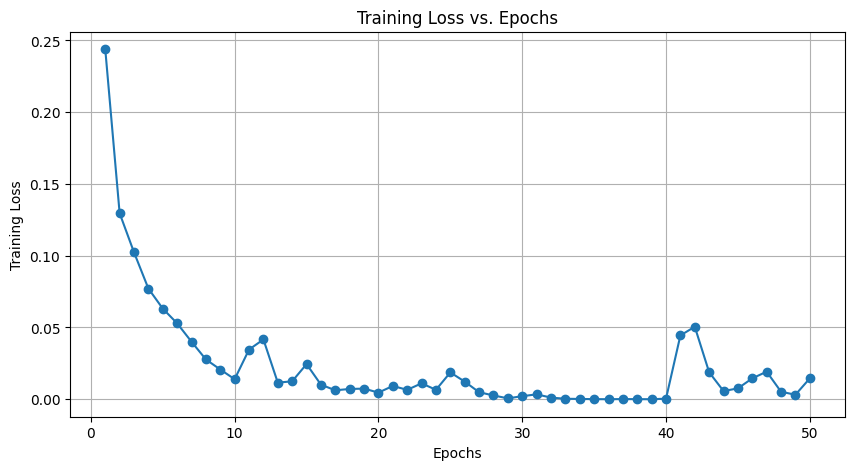

Testing Model 1 (Autoencoder) for Client 4...
Model 1 Test Accuracy: 95.94%
Testing Model 2 for Client 4...
Model 2 Test Loss: 1.0960, Test Accuracy: 85.75%
Testing Model 4 for Client 4...
Model 4 Test Loss: 0.1706, Test Accuracy: 95.13%


In [20]:
client_model_parameters = []
model3_datasets = [client_datasets[client_id]['model3'] for client_id in range(len(client_data_list))]
criterion2 = nn.CrossEntropyLoss()

# Train and test models for each client
for client_id in range(len(client_data_list)):
    # Retrieve pre-created datasets for the current client
    model1_train_test = client_datasets[client_id]['model1']
    model2_train_test = client_datasets[client_id]['model2']
    model3_train_test = client_datasets[client_id]['model3']
    model4_train_test = client_datasets[client_id]['model4']

    # Create model instances and move them to device
    model1 = Autoencoder().to(device)  # Use the autoencoder as Model 1
    model2 = Model2().to(device)
    model4 = Model4().to(device)  # Model 4 instance

    # Define loss functions and optimizers
    criterion1 = autoencoder_loss  # For Autoencoder reconstruction loss
    optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
    optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
    optimizer4 = optim.Adam(model4.parameters(), lr=0.001)
    print(f'Training for Client {client_id} with private labels {client_private_labels[client_id]} and common labels {client_common_labels[client_id]}...')

    # Training Autoencoder (Model 1) with threshold tuning
    print(f'Training Model 1 (Autoencoder) for Client {client_id}...')
    train_loader1 = DataLoader(model1_train_test[0], batch_size=128, shuffle=True,num_workers=4)
    model1, threshold1 = train_autoencoder_with_threshold(model1, train_loader1, criterion1, optimizer1)

    # Train Model 2
    print(f'Training Model 2 for Client {client_id}...')
    train_loader2 = DataLoader(model2_train_test[0], batch_size=64, shuffle=True,num_workers=4)
    train_model(model2, train_loader2, criterion2, optimizer2)
    
    # Train Model 4
    print(f'Training Model 4 for Client {client_id} with labels {client_private_labels[client_id]}...')
    train_loader4 = DataLoader(model4_train_test[0], batch_size=64, shuffle=True,num_workers=4)
    train_model(model4, train_loader4, criterion2, optimizer4)
    
    client_model_parameters.append({
        'model1': model1.state_dict(),
        'threshold1': threshold1,  # Store threshold for Model 1
        'model2': model2.state_dict(),
        'model4': model4.state_dict()
    })
    # Testing Autoencoder (Model 1) with determined threshold
    print(f'Testing Model 1 (Autoencoder) for Client {client_id}...')
    test_loader1 = DataLoader(model1_train_test[1], batch_size=32)
    test_accuracy1 = test_autoencoder(model1, test_loader1, threshold1)
    print(f'Model 1 Test Accuracy: {test_accuracy1:.2f}%')

    # Test Model 2
    print(f'Testing Model 2 for Client {client_id}...')
    test_loader2 = DataLoader(model2_train_test[1], batch_size=32)
    test_loss2, test_accuracy2 = test_model(model2, test_loader2, criterion2)
    print(f'Model 2 Test Loss: {test_loss2:.4f}, Test Accuracy: {test_accuracy2:.2f}%')
    # Test Model 4
    print(f'Testing Model 4 for Client {client_id}...')
    test_loader4 = DataLoader(model4_train_test[1], batch_size=32)
    test_loss4, test_accuracy4 = test_model(model4, test_loader4, criterion2)
    print(f'Model 4 Test Loss: {test_loss4:.4f}, Test Accuracy: {test_accuracy4:.2f}%')

# Initialize the global model for Model 3
#global_model3 = Model3().to(device)  # Updated Model3 for CIFAR input


Federated Learning Round 1 for Model 3


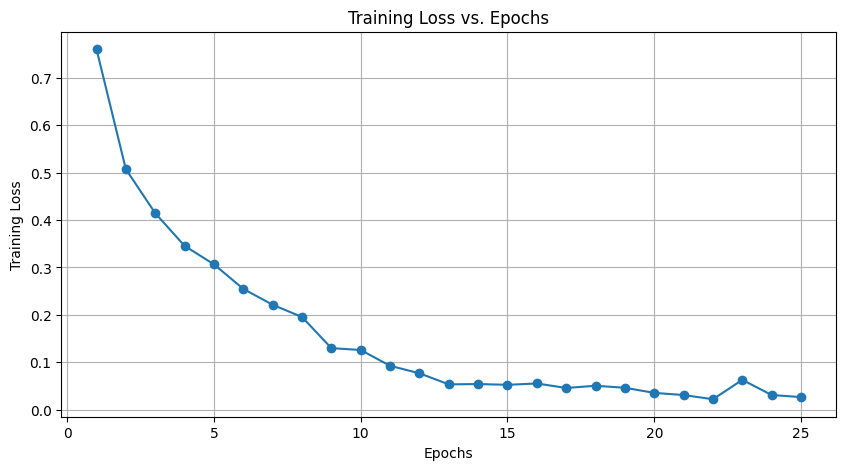

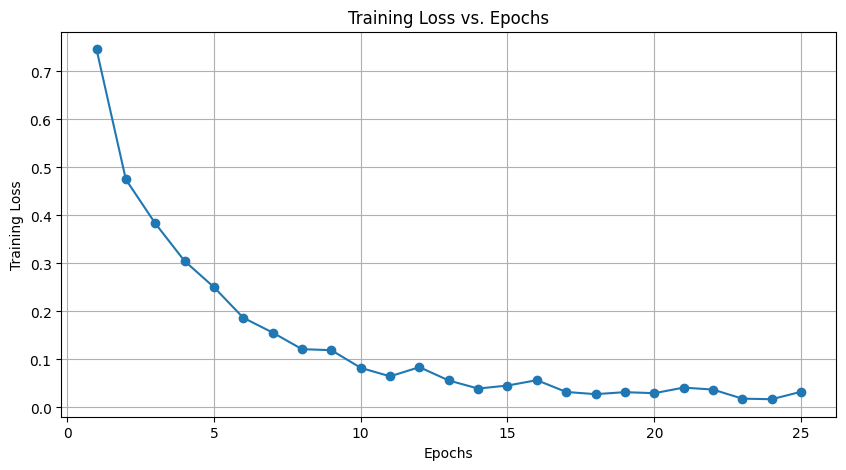

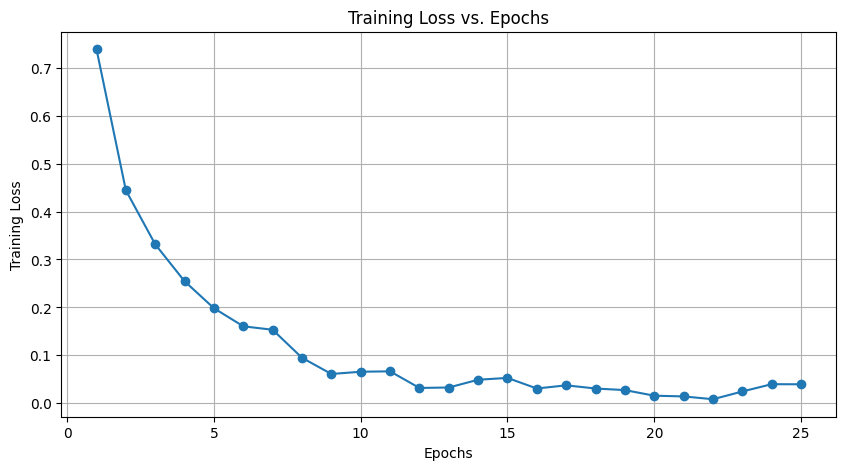


Federated Learning Round 2 for Model 3


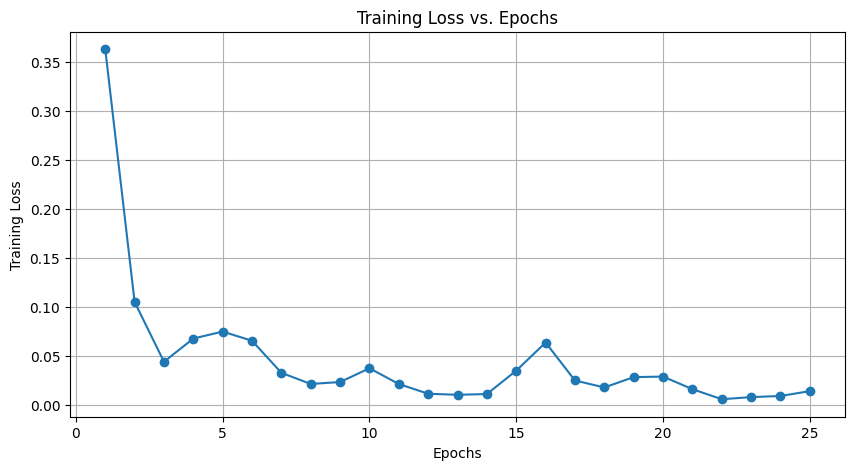

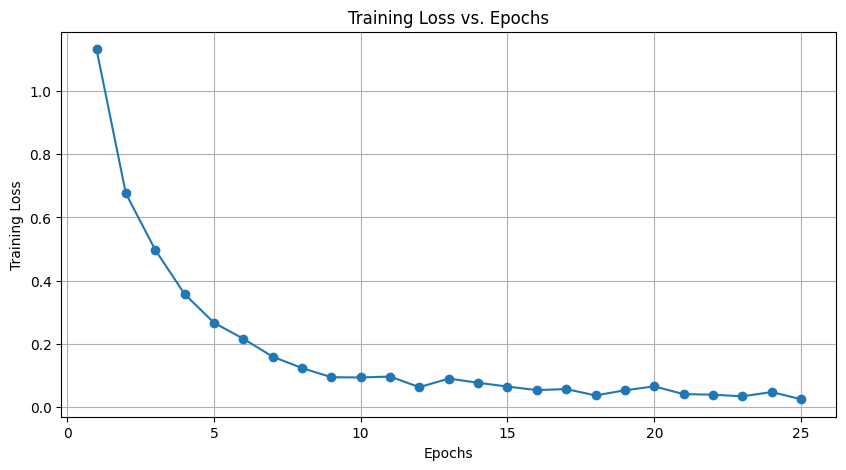

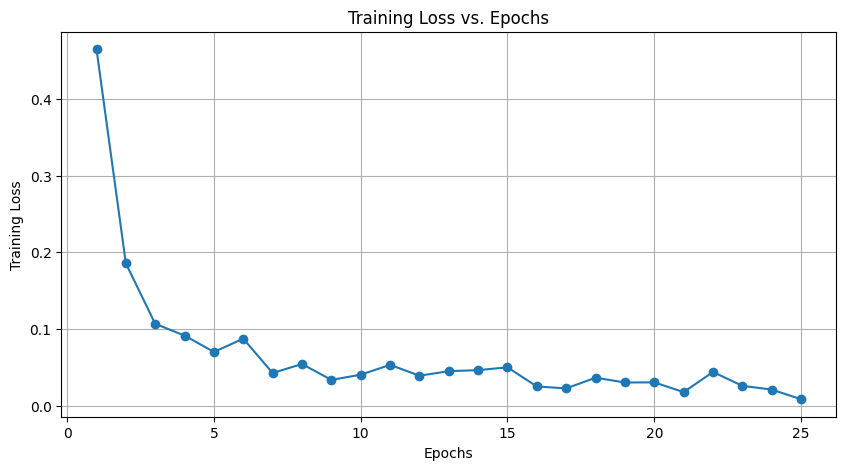


Federated Learning Round 3 for Model 3


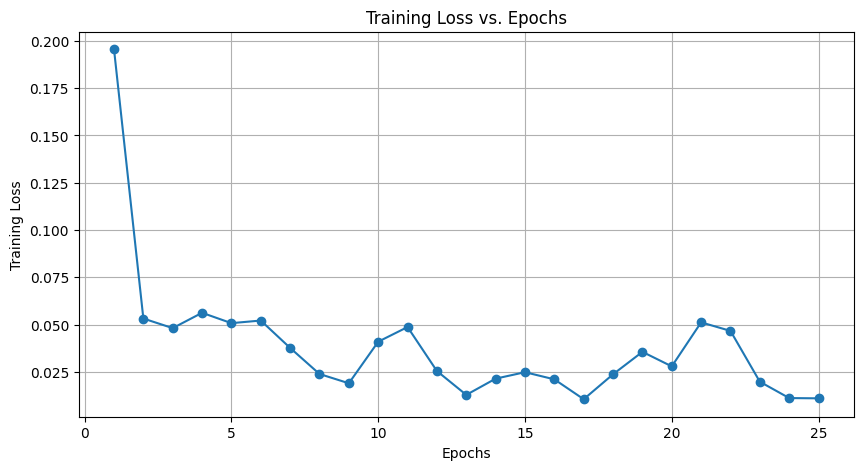

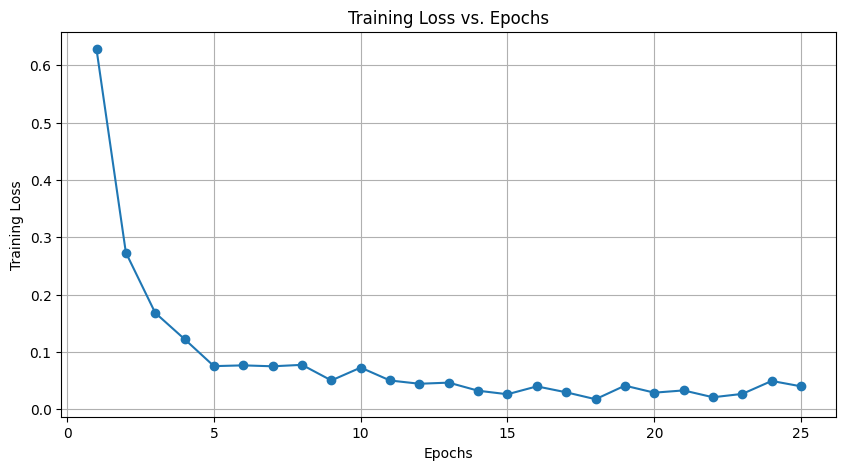

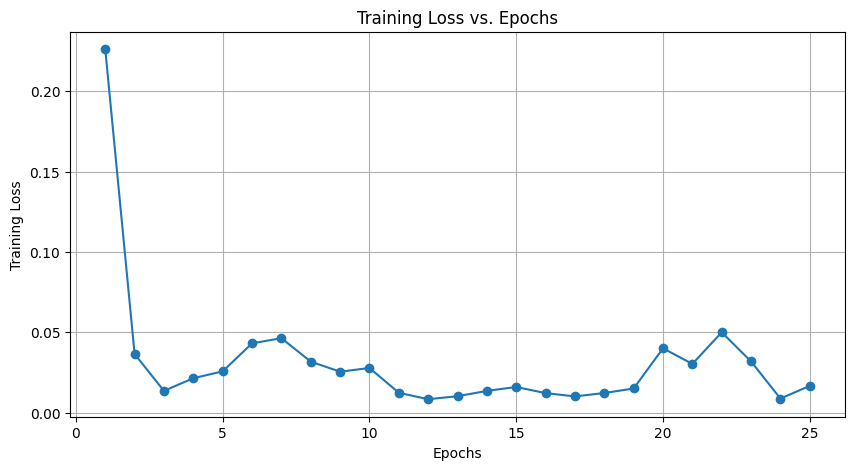


Federated Learning Round 4 for Model 3


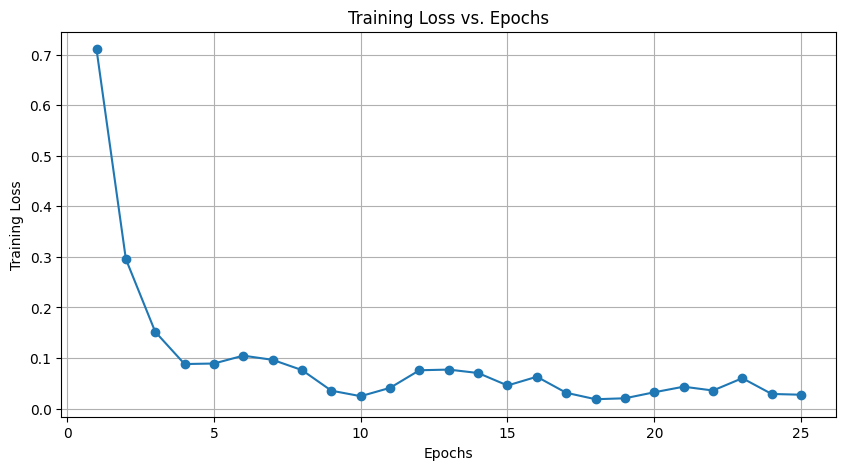

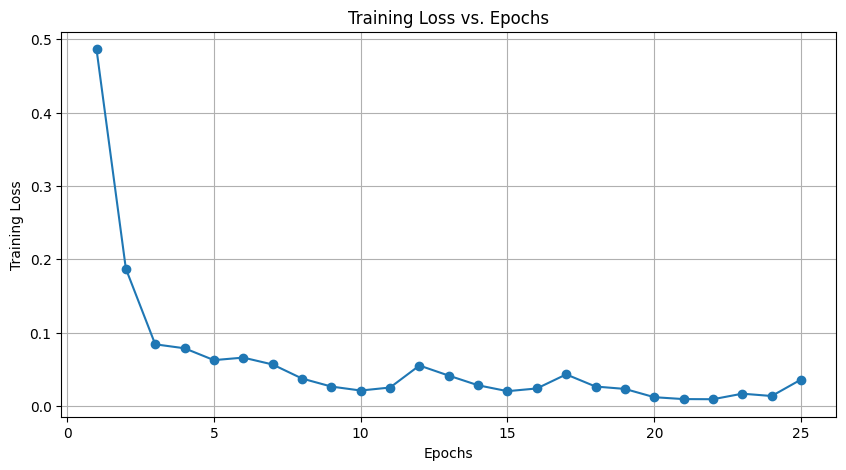

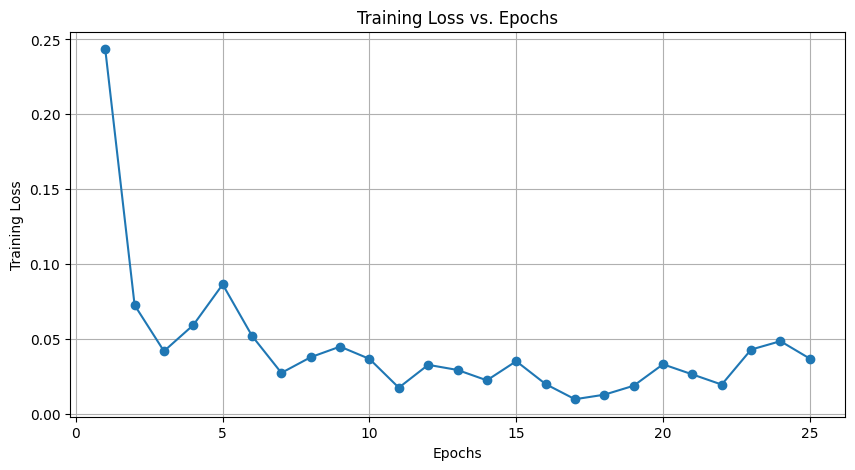


Federated Learning Round 5 for Model 3


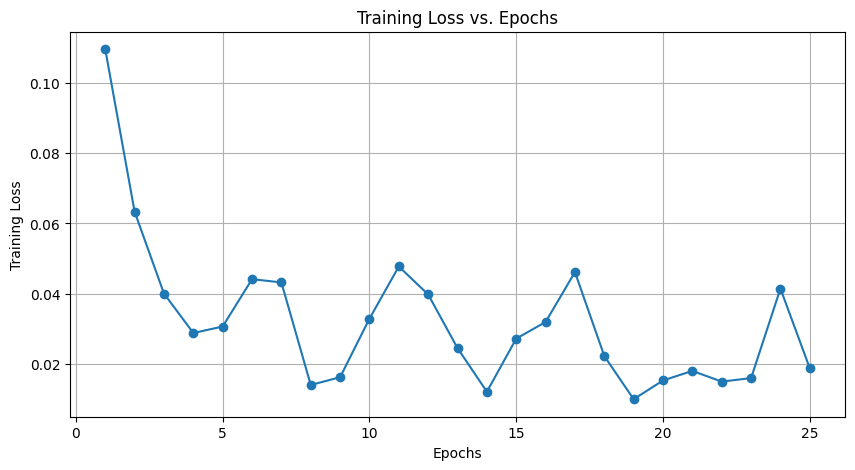

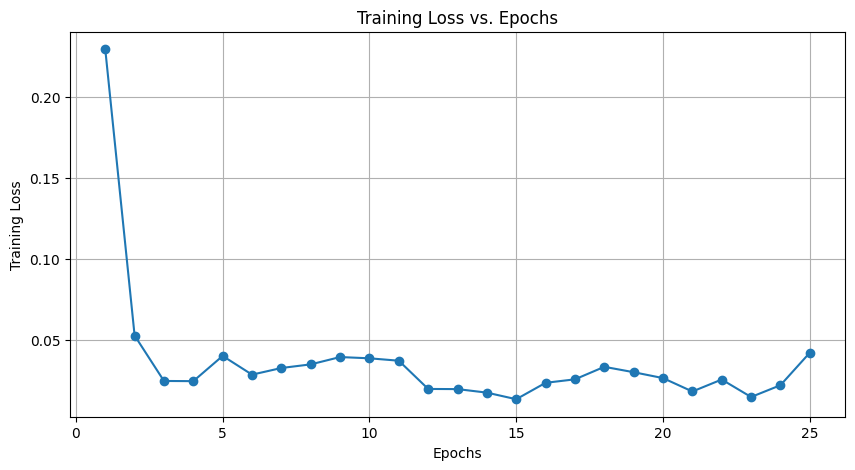

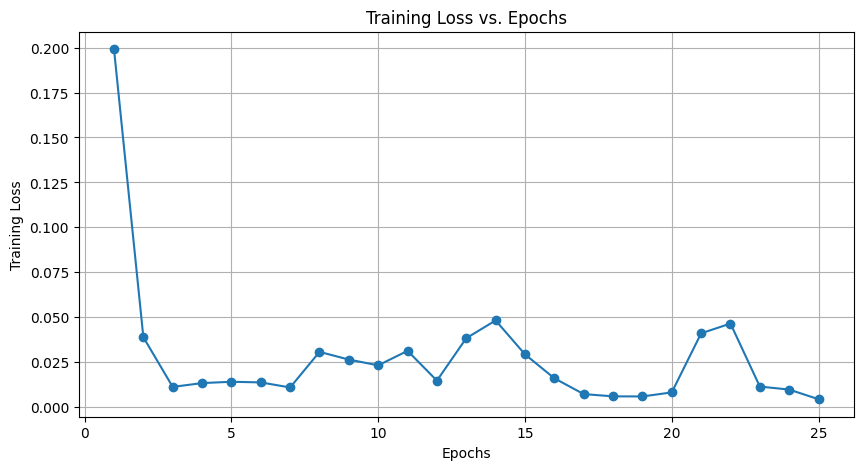


Federated Learning Round 6 for Model 3


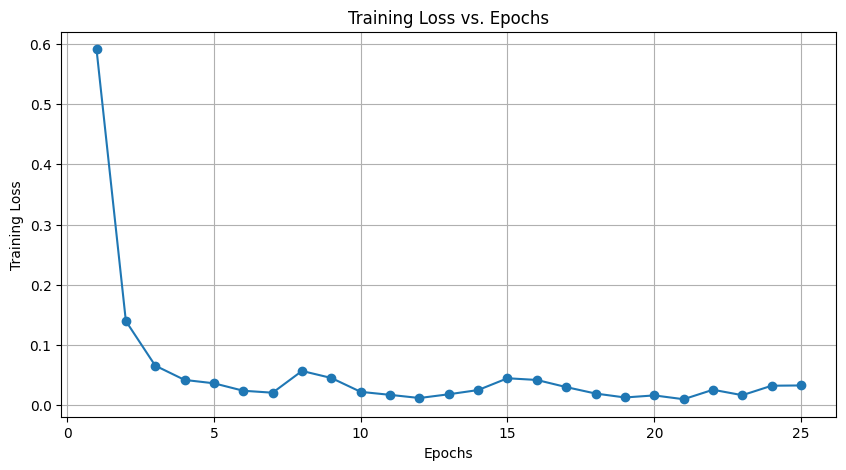

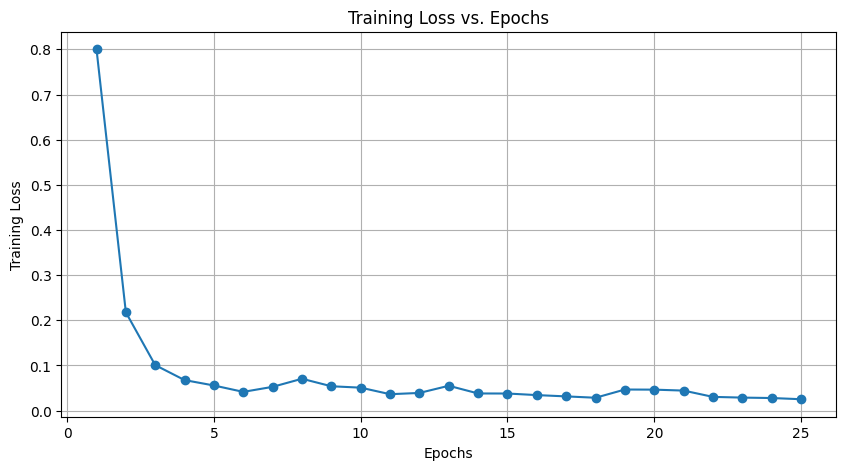

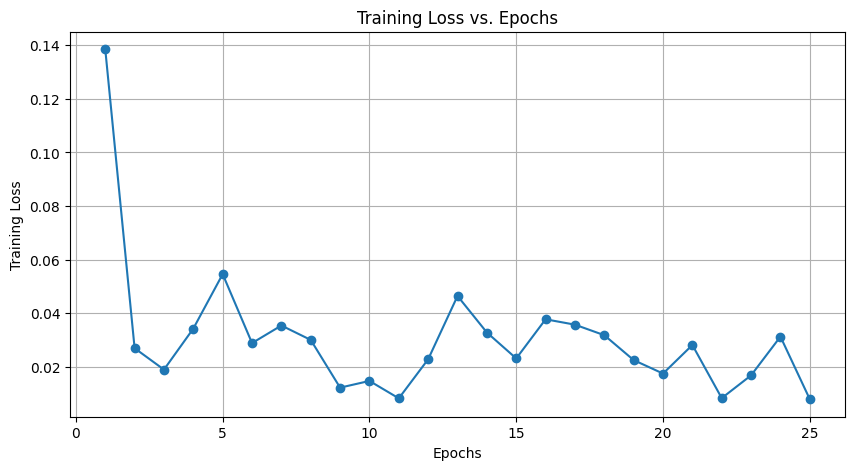


Federated Learning Round 7 for Model 3


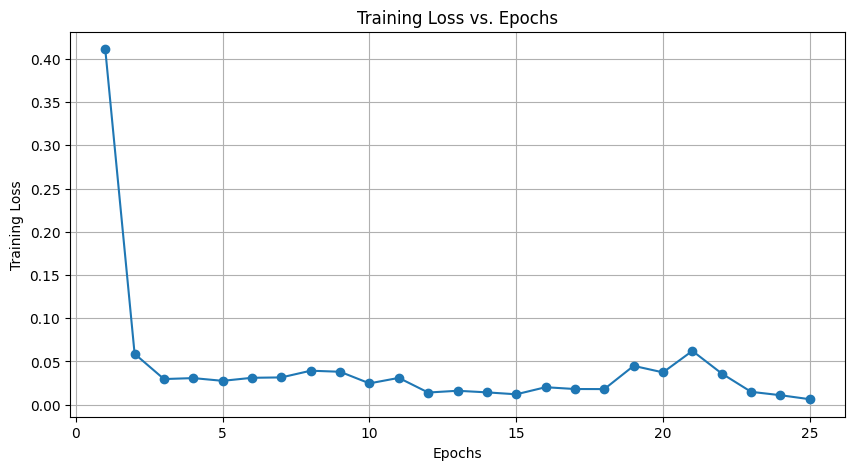

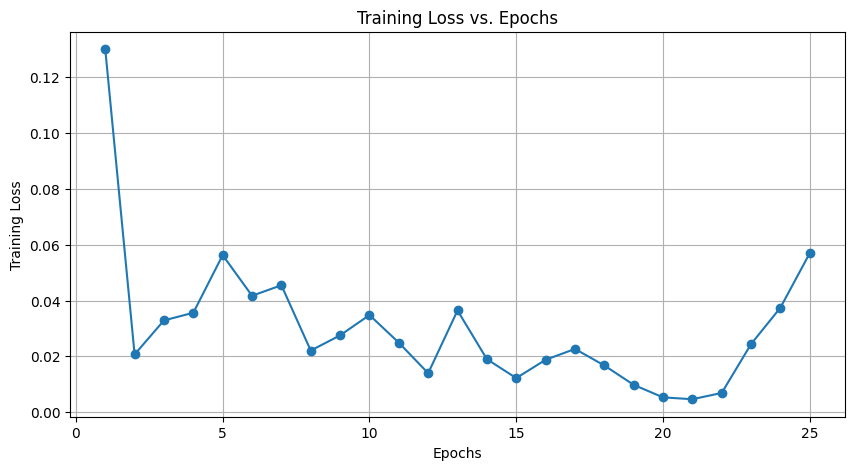

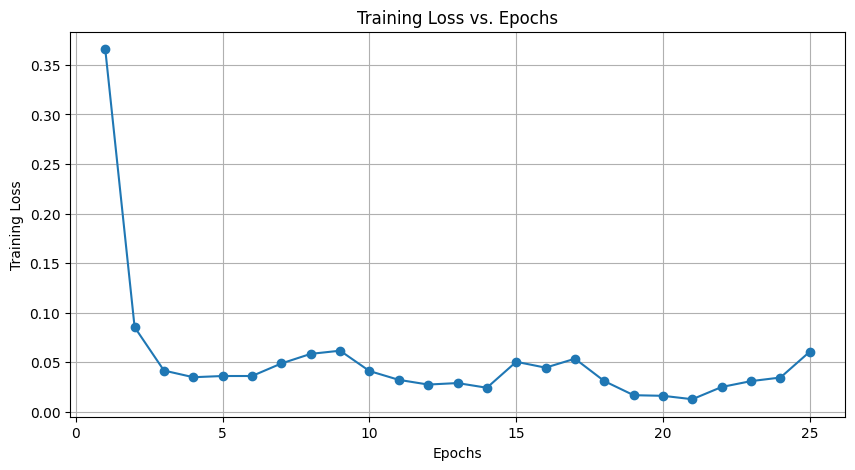


Federated Learning Round 8 for Model 3


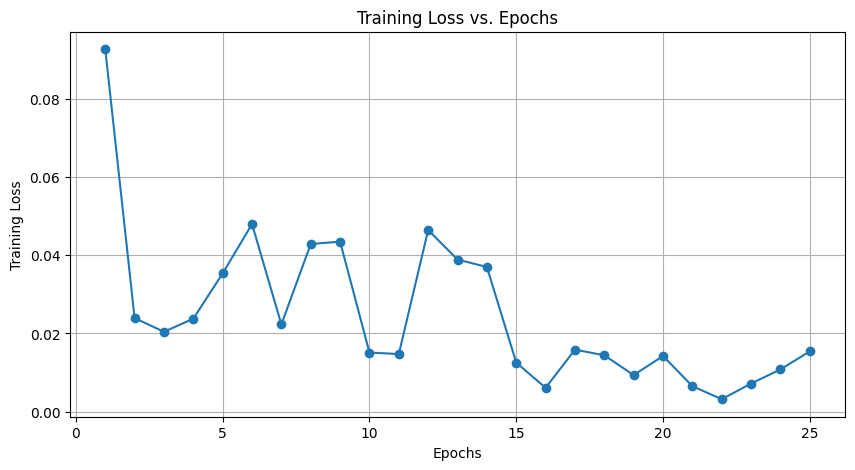

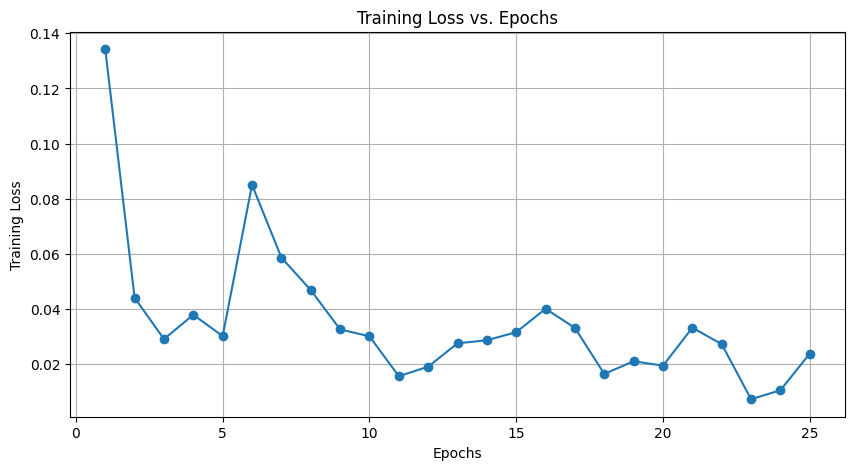

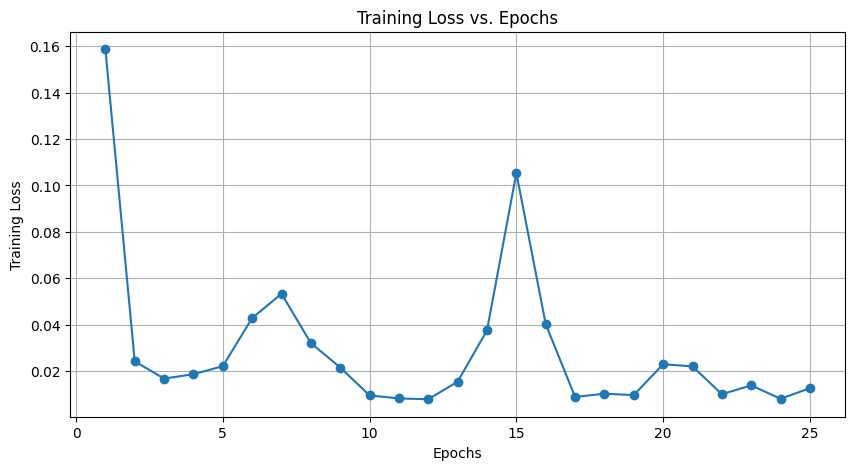


Federated Learning Round 9 for Model 3


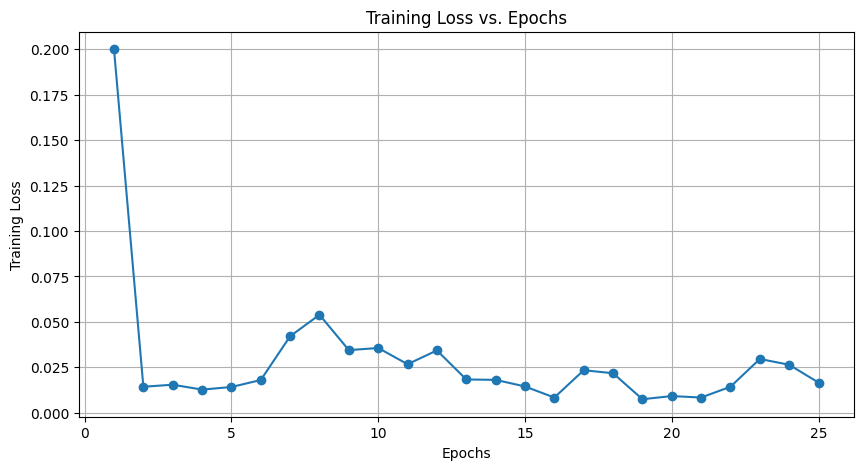

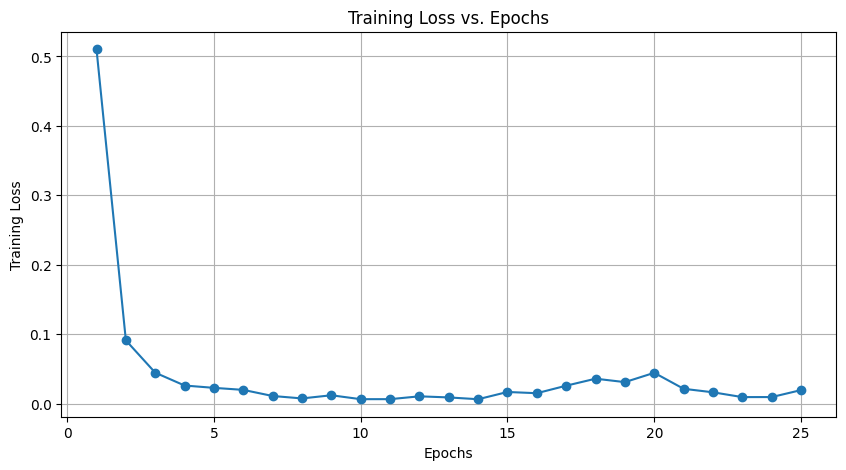

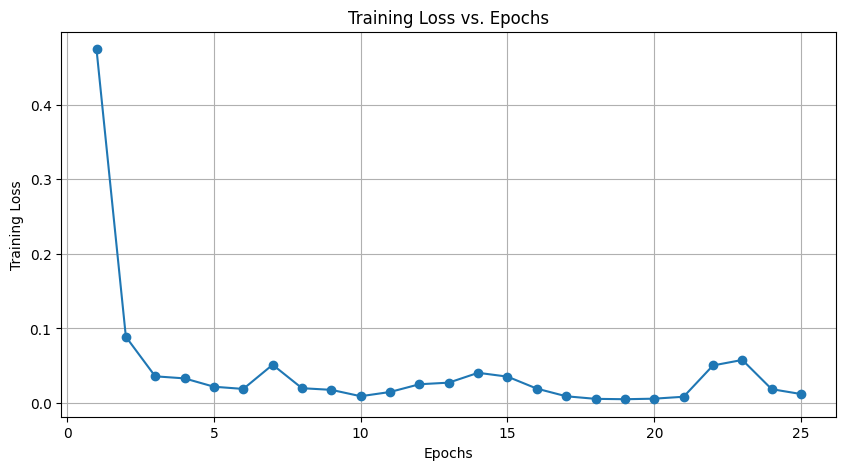


Federated Learning Round 10 for Model 3


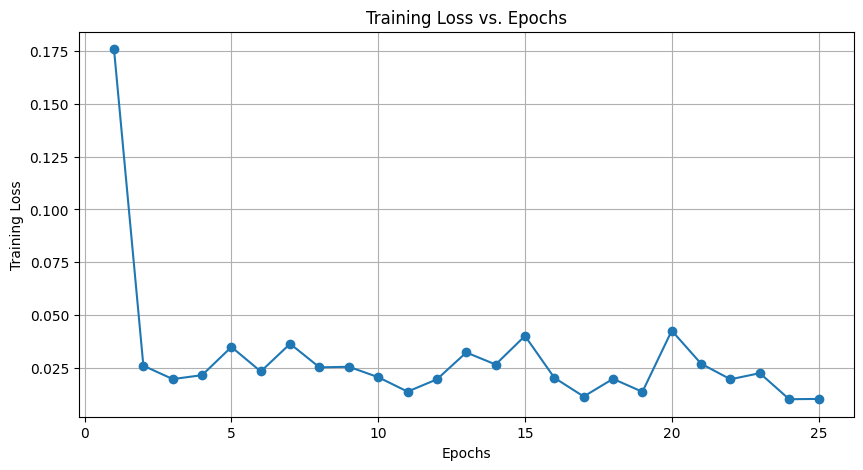

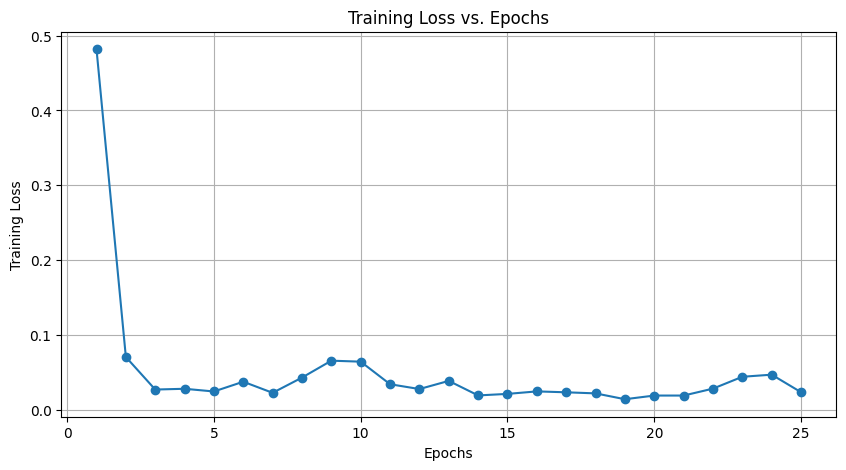

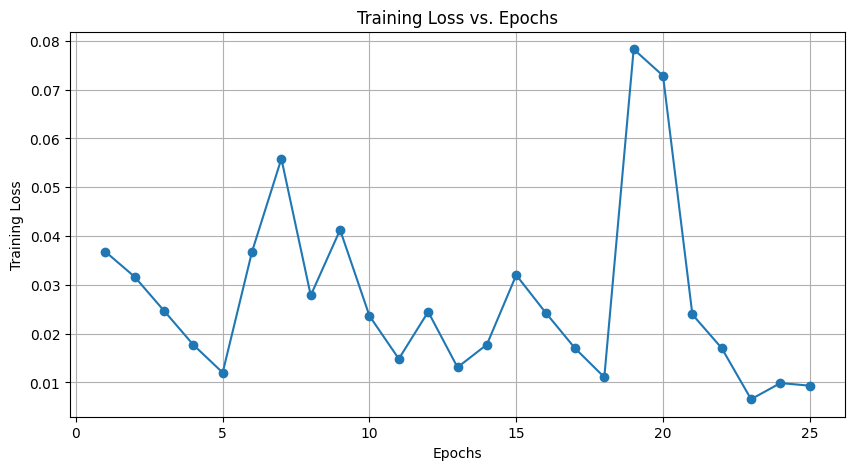


Federated Learning Round 11 for Model 3


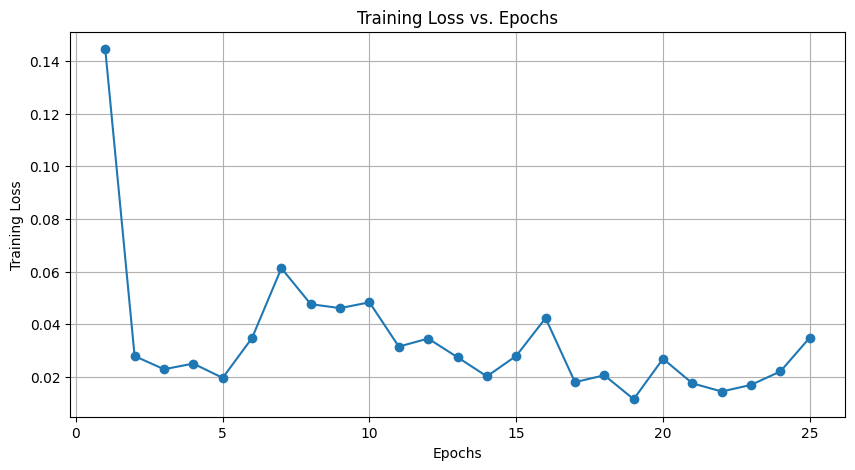

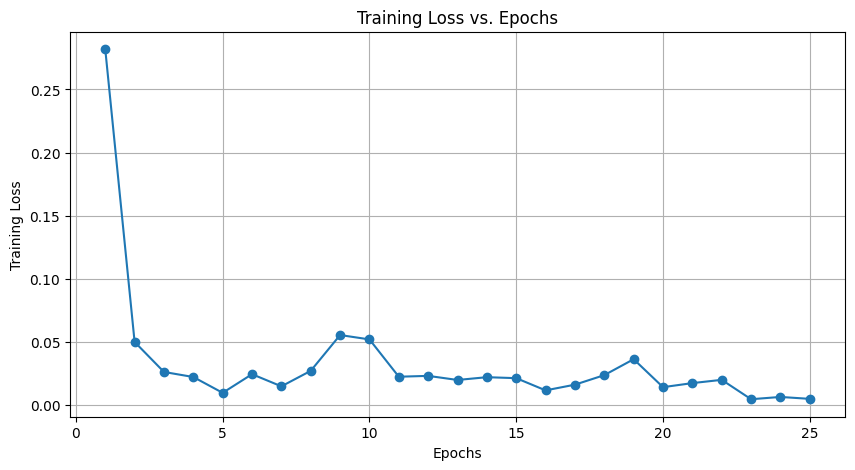

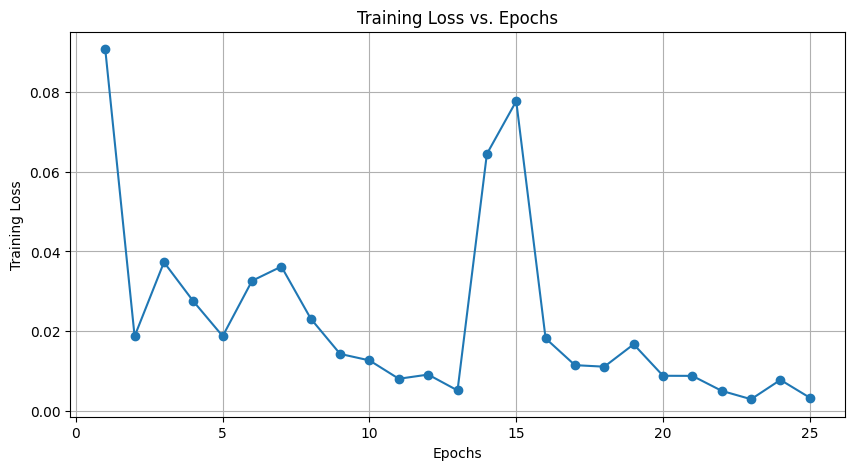


Federated Learning Round 12 for Model 3


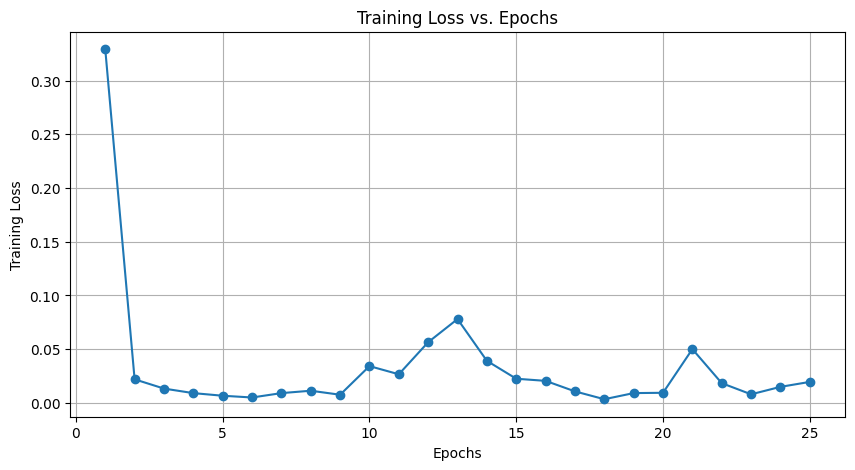

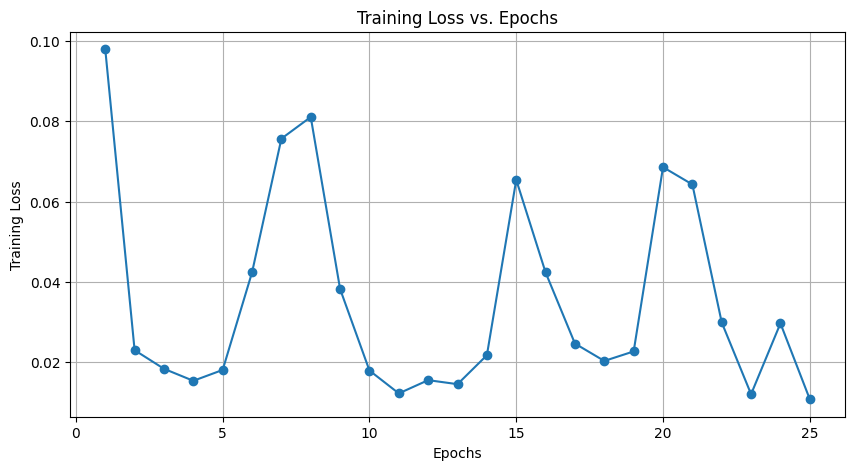

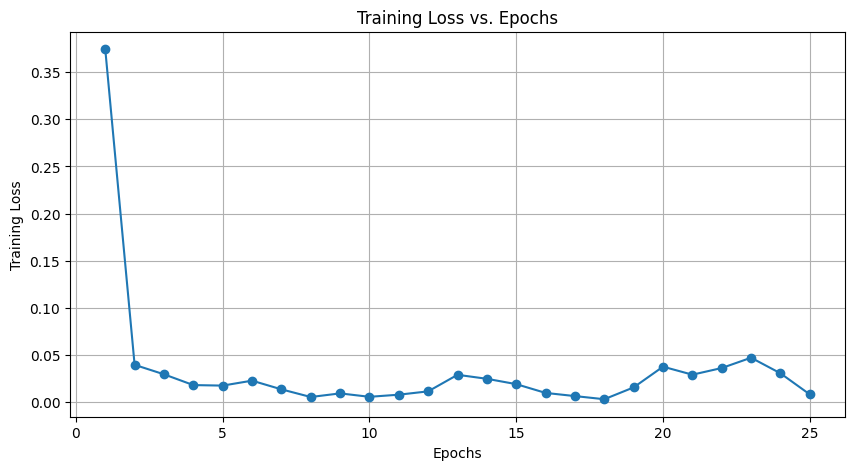


Federated Learning Round 13 for Model 3


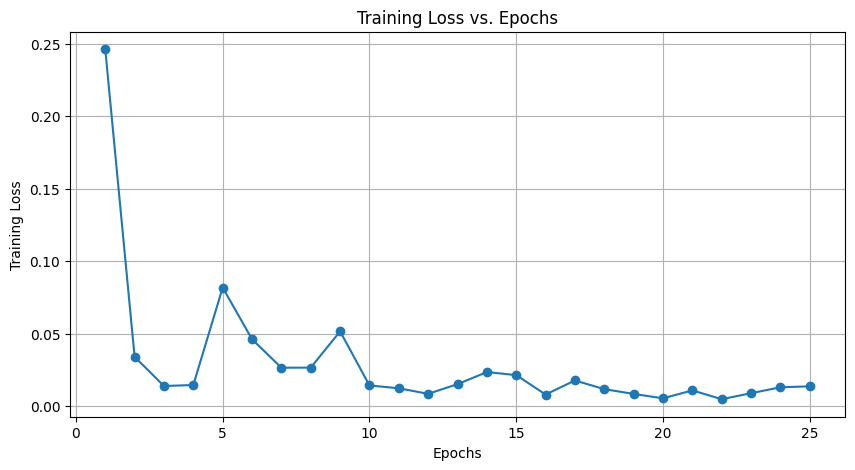

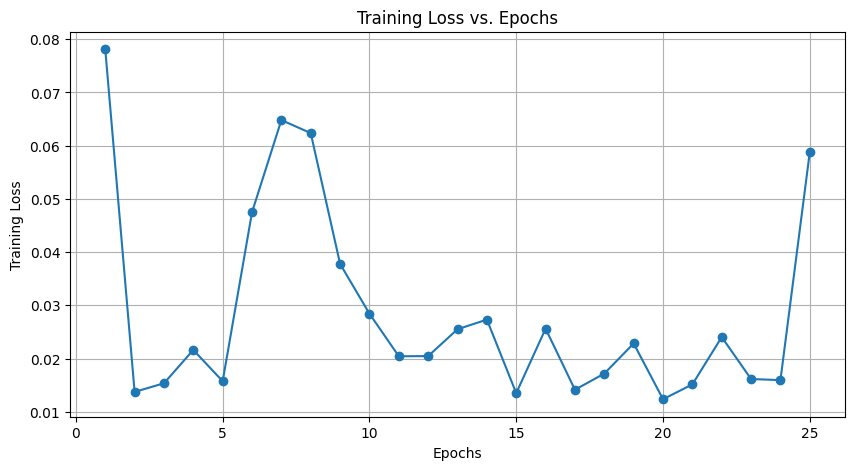

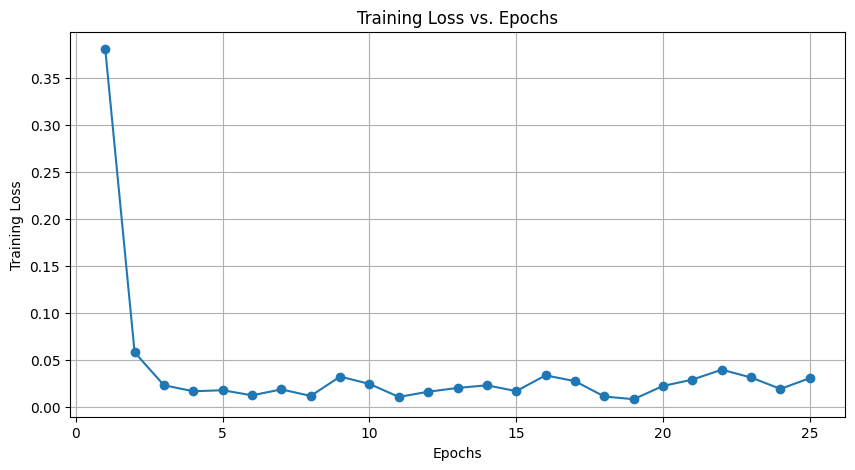


Federated Learning Round 14 for Model 3


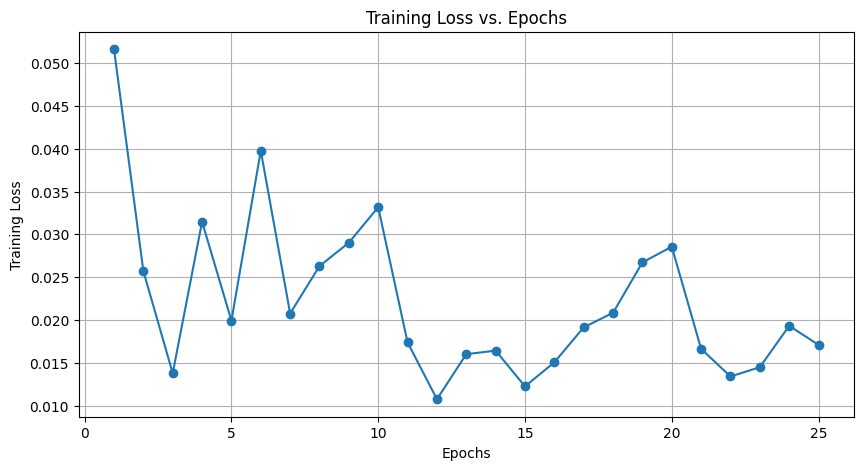

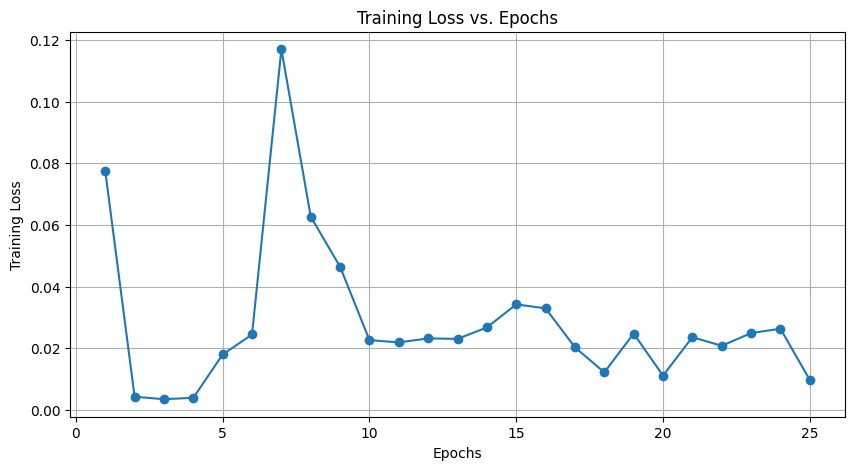

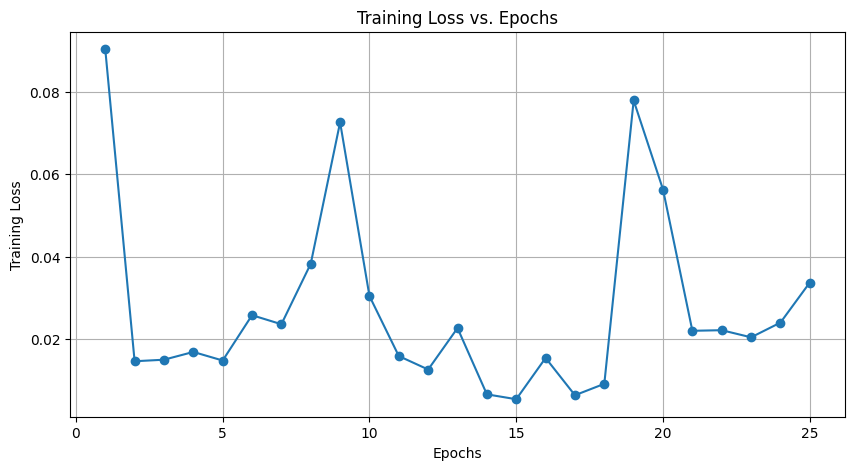


Federated Learning Round 15 for Model 3


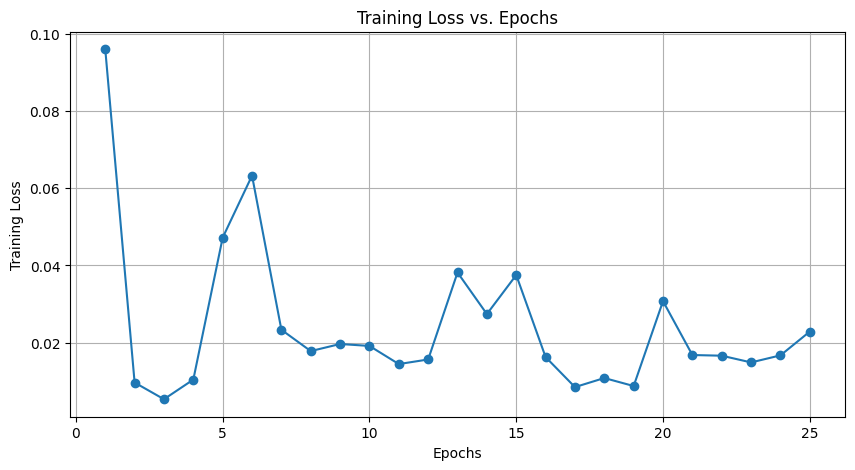

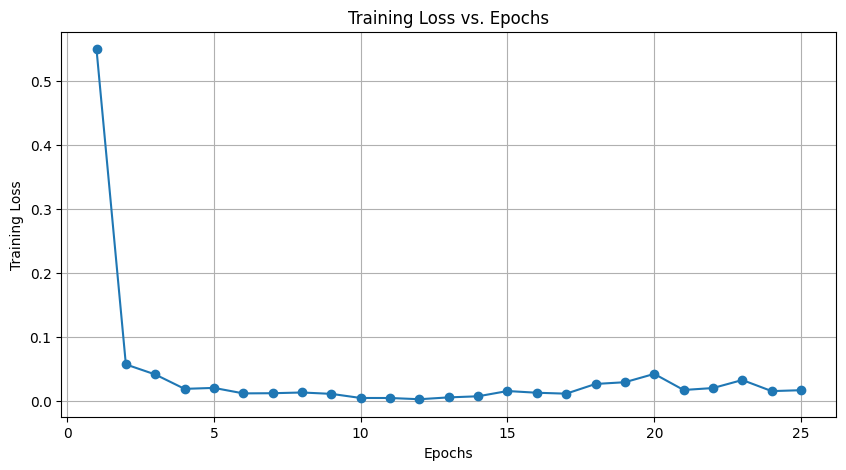

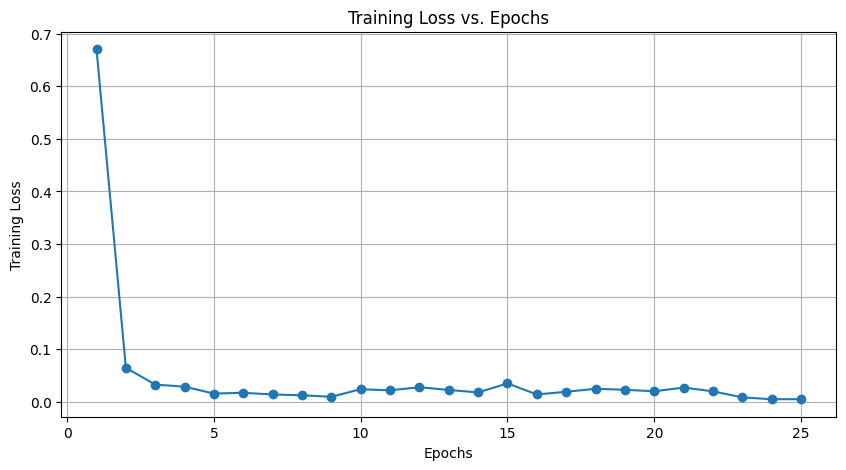


Federated Learning Round 16 for Model 3


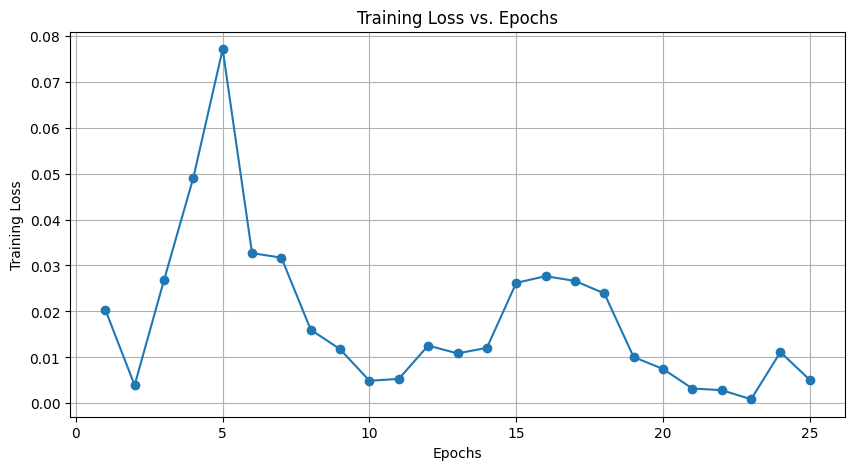

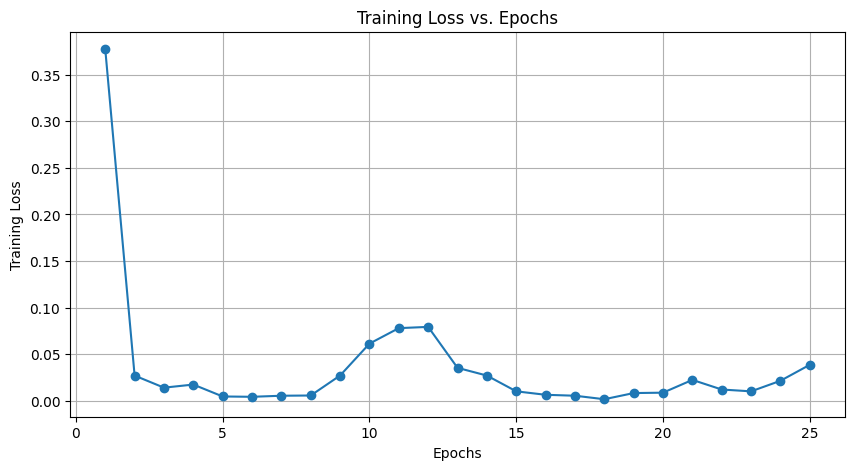

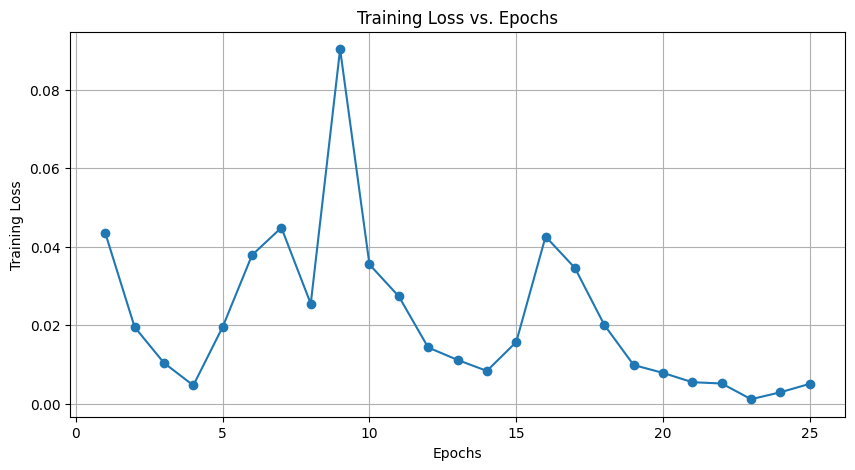


Federated Learning Round 17 for Model 3


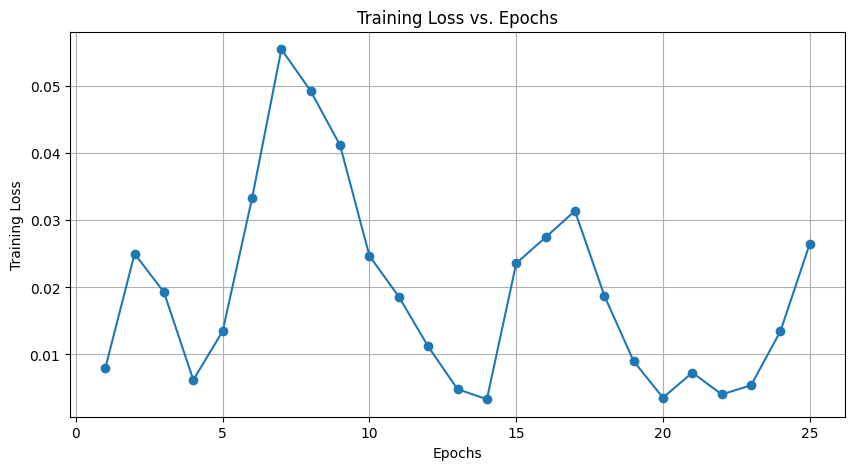

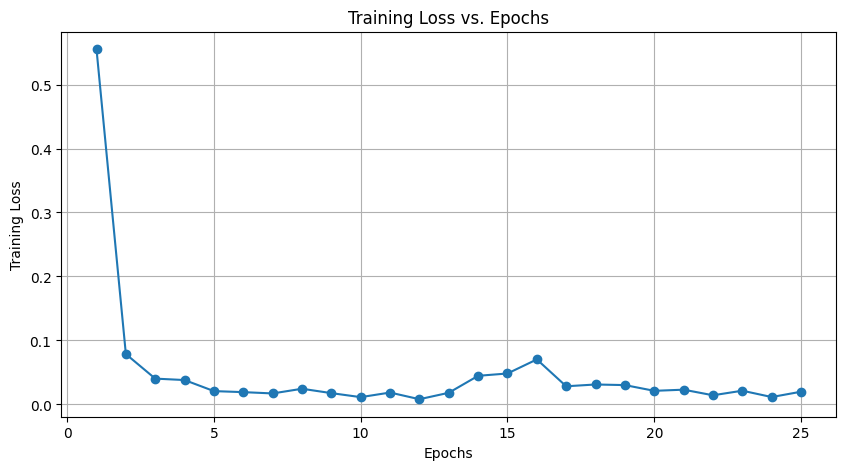

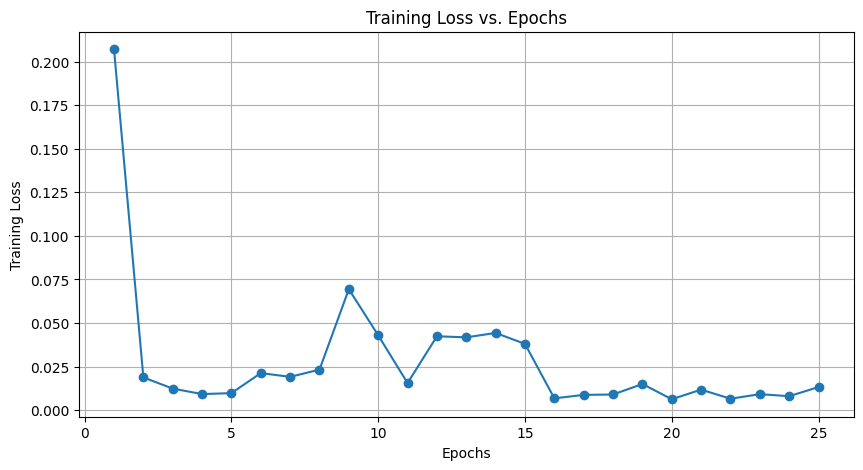


Federated Learning Round 18 for Model 3


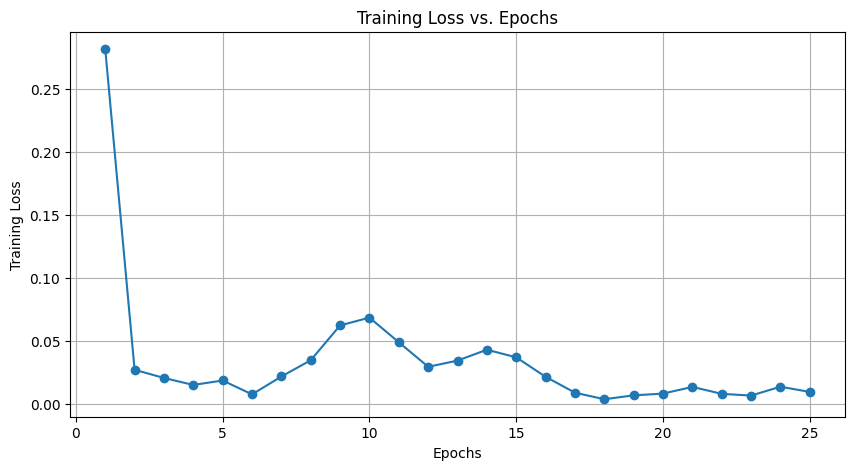

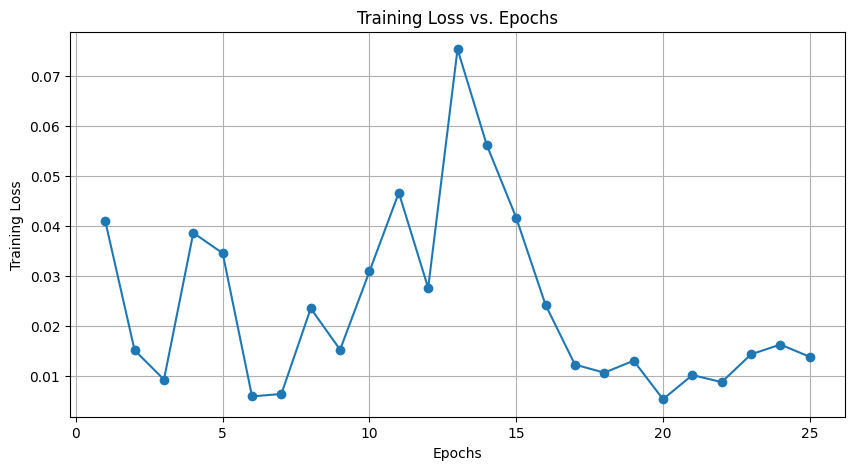

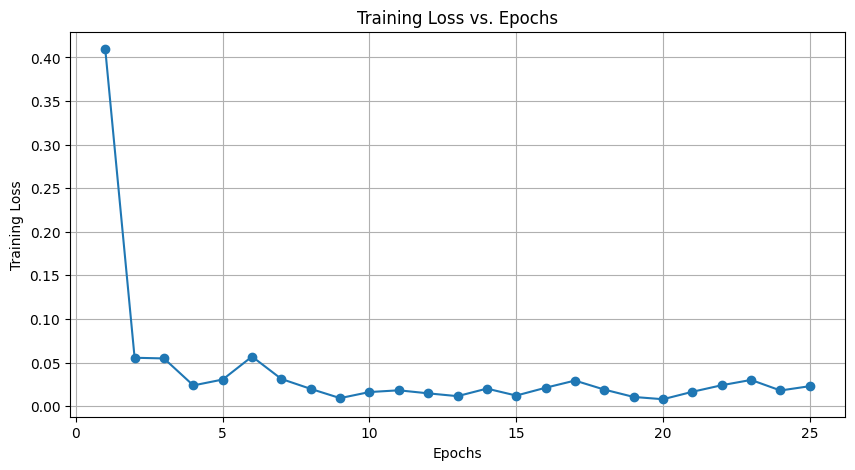


Federated Learning Round 19 for Model 3


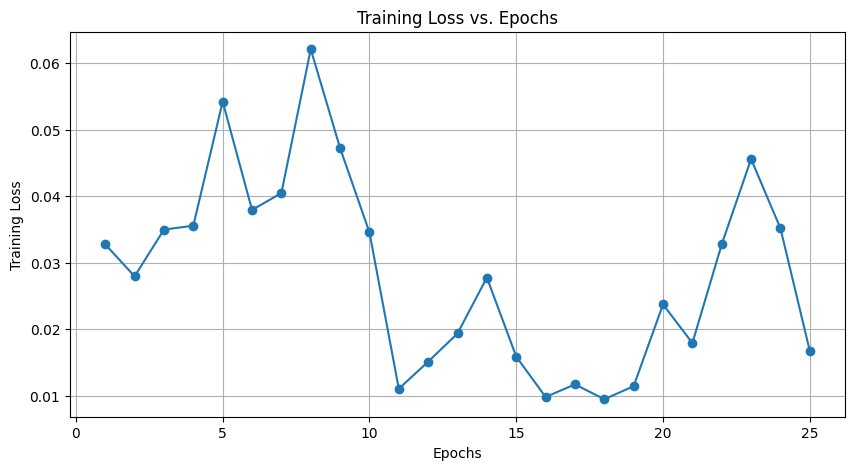

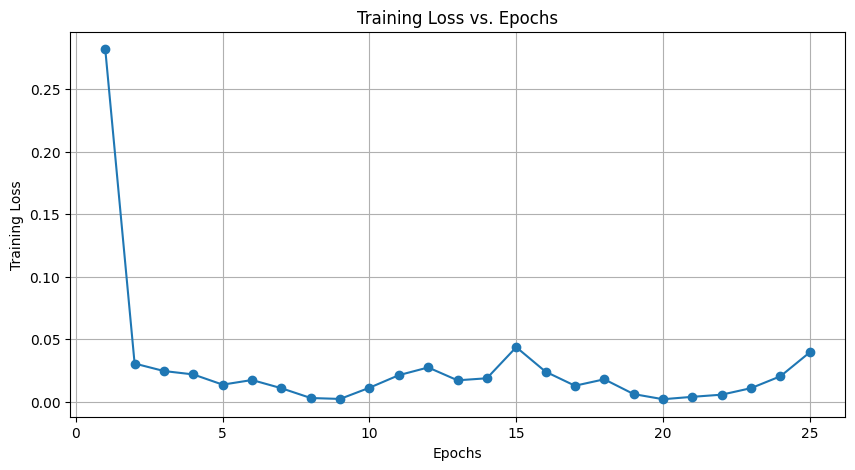

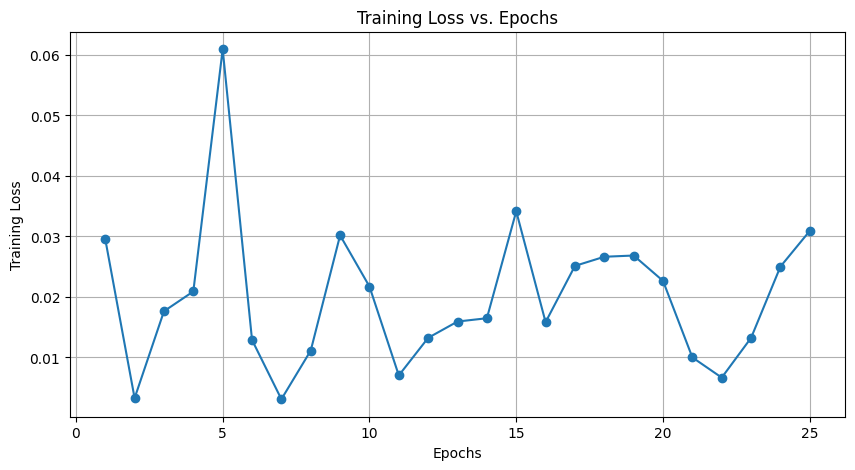


Federated Learning Round 20 for Model 3


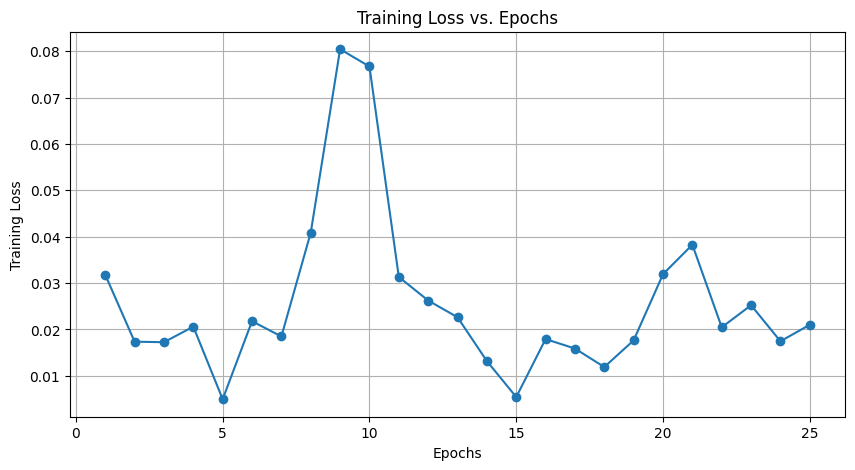

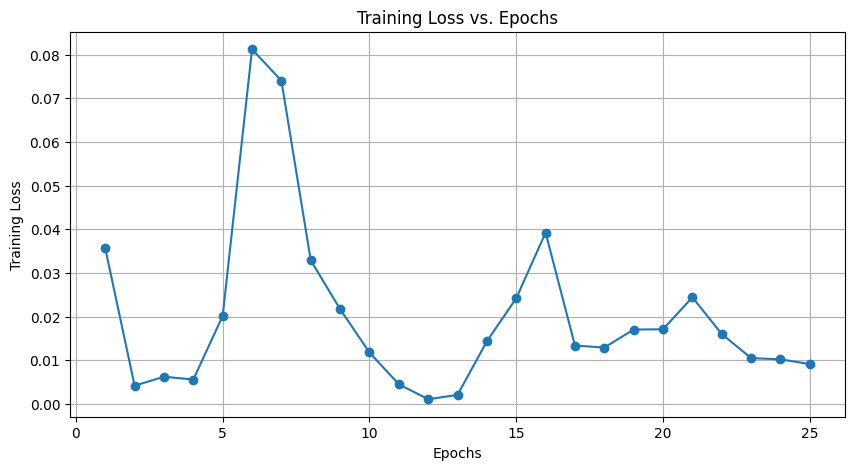

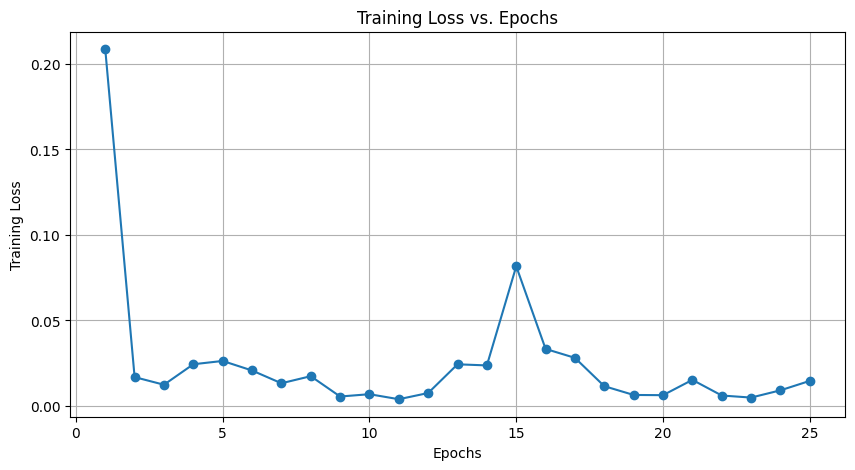


Federated Learning Round 21 for Model 3


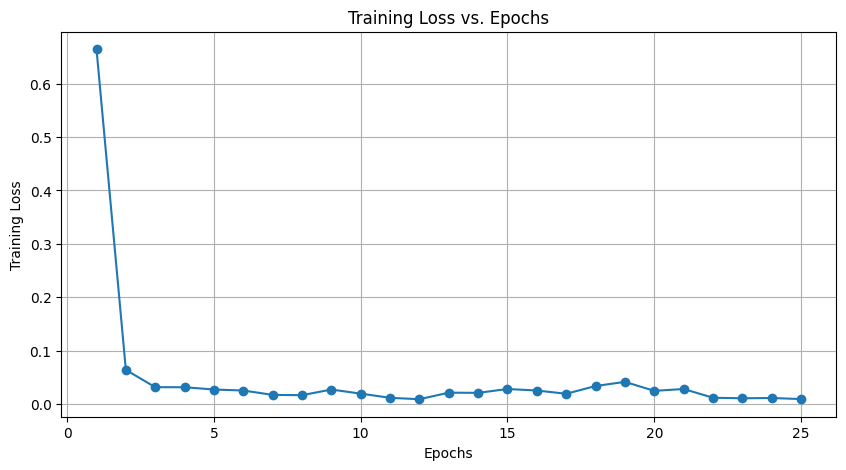

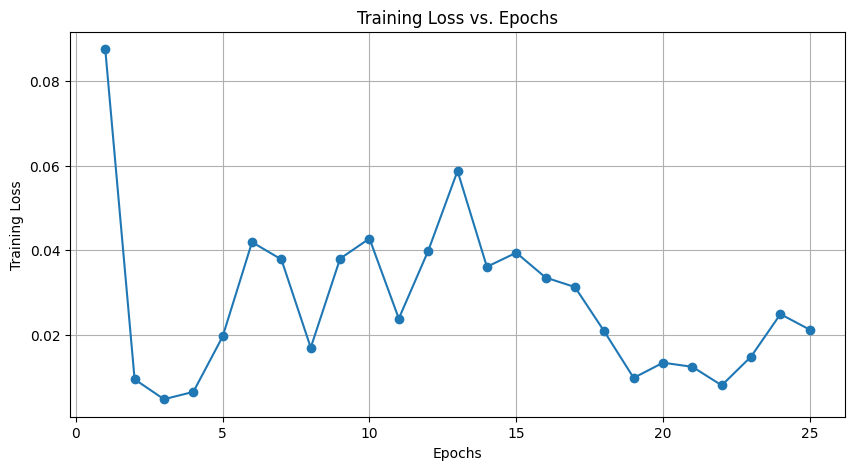

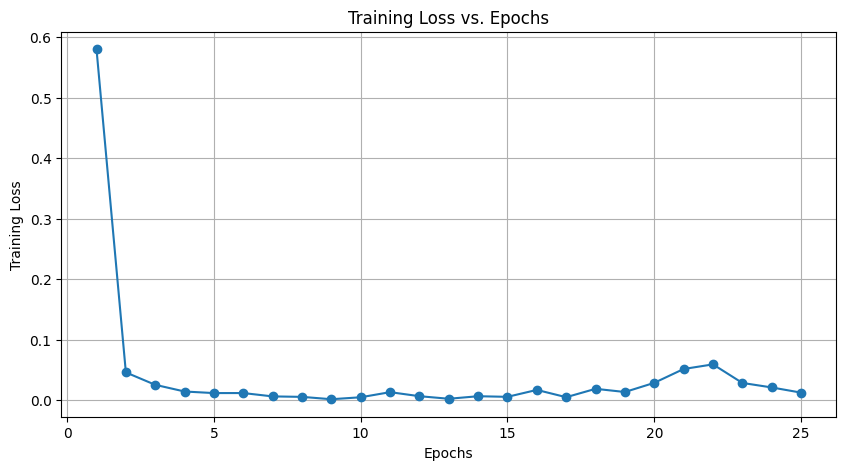


Federated Learning Round 22 for Model 3


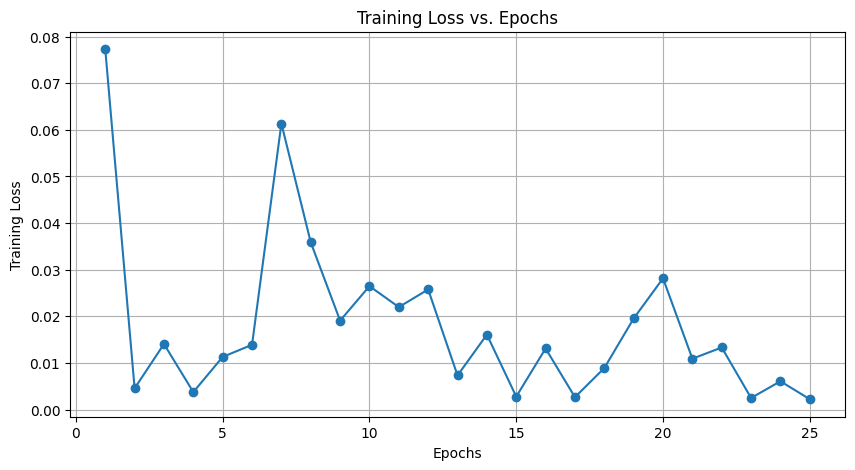

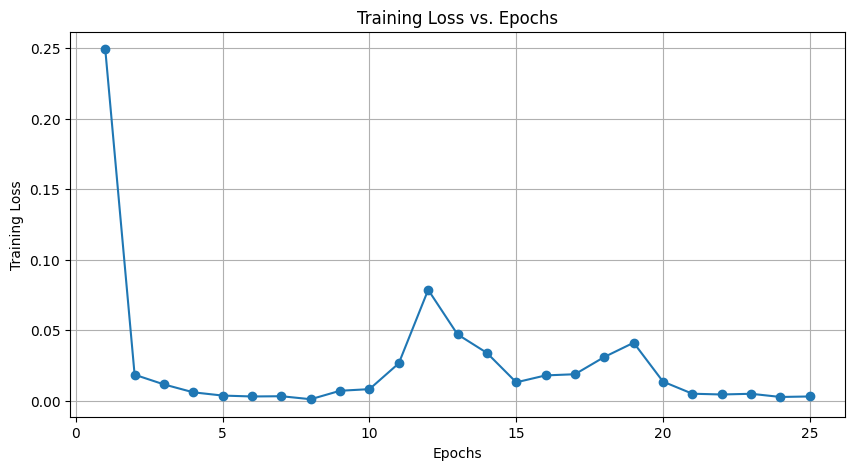

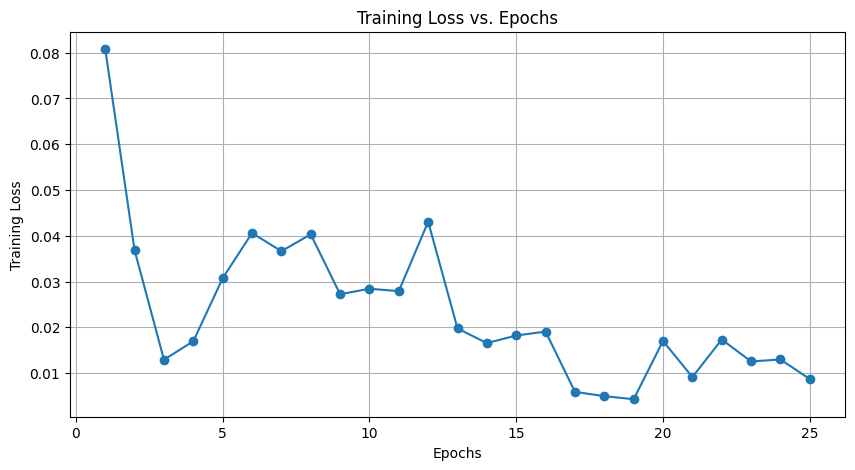


Federated Learning Round 23 for Model 3


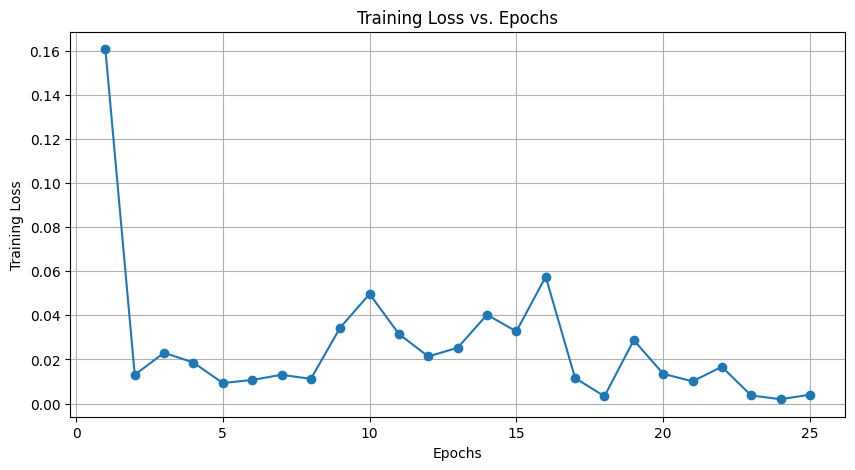

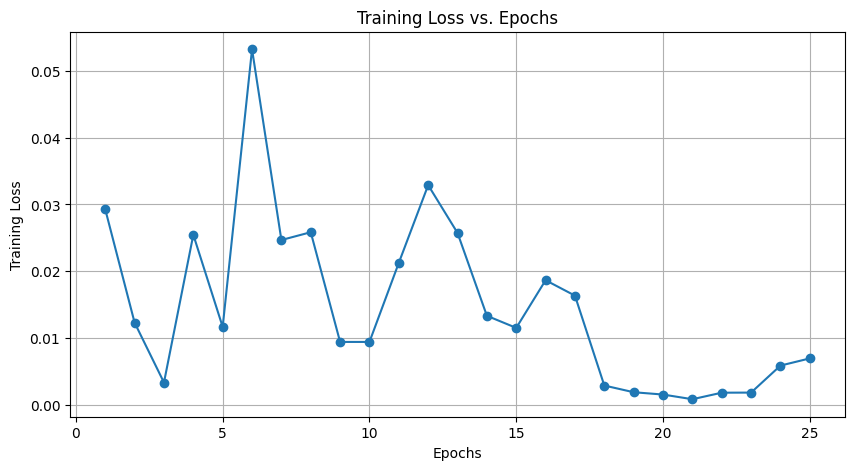

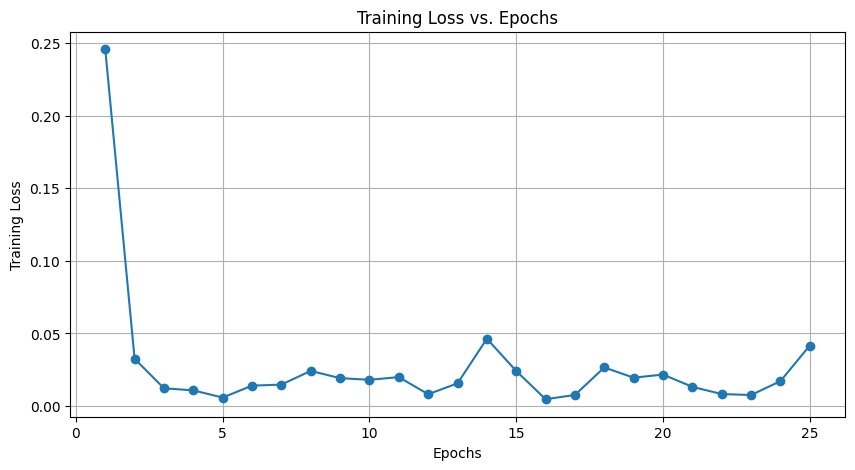


Federated Learning Round 24 for Model 3


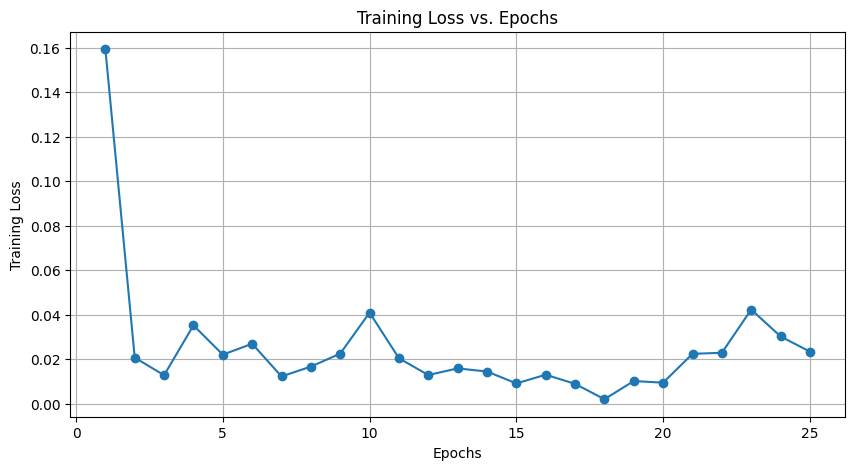

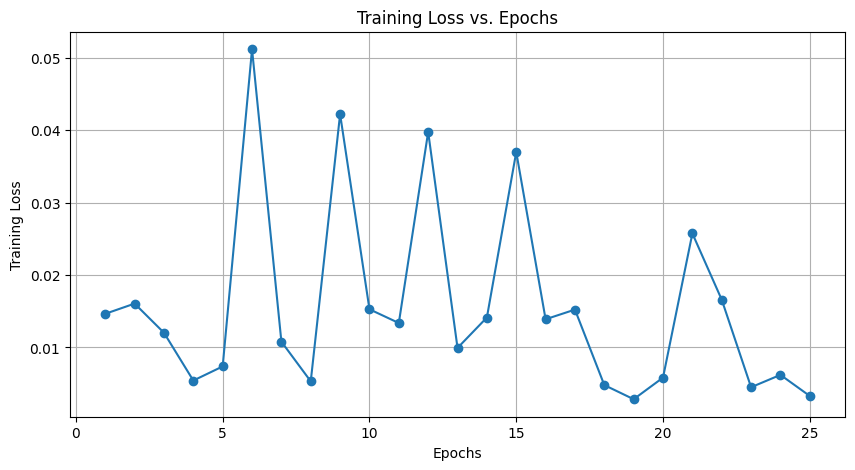

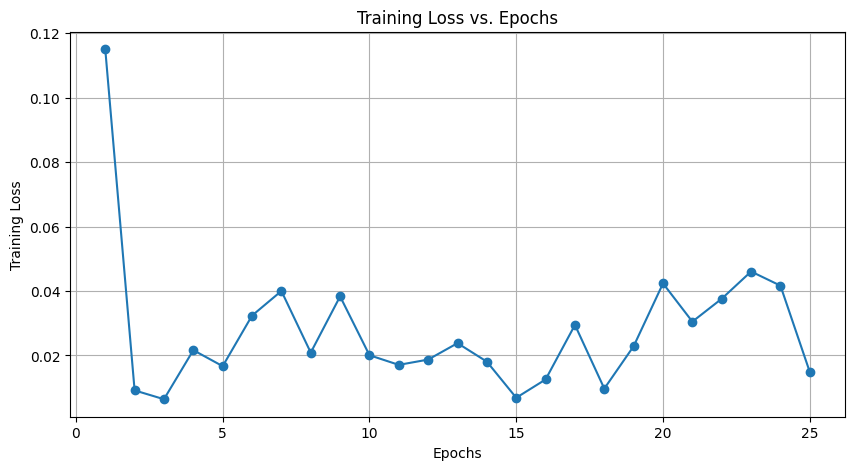


Federated Learning Round 25 for Model 3


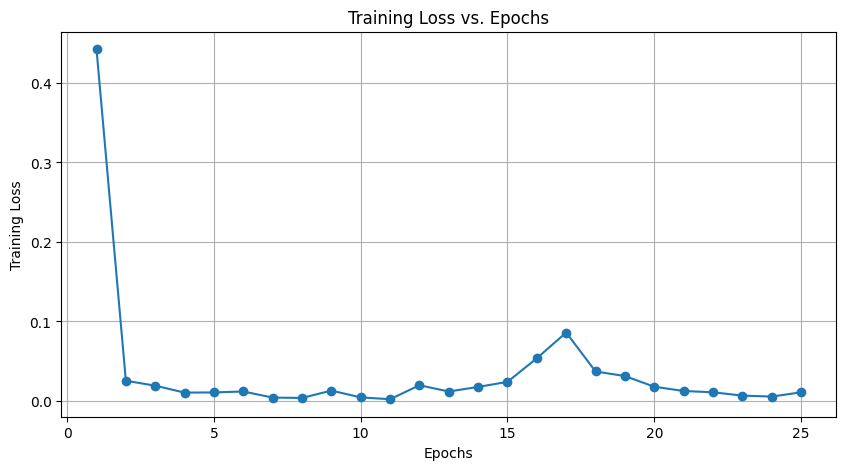

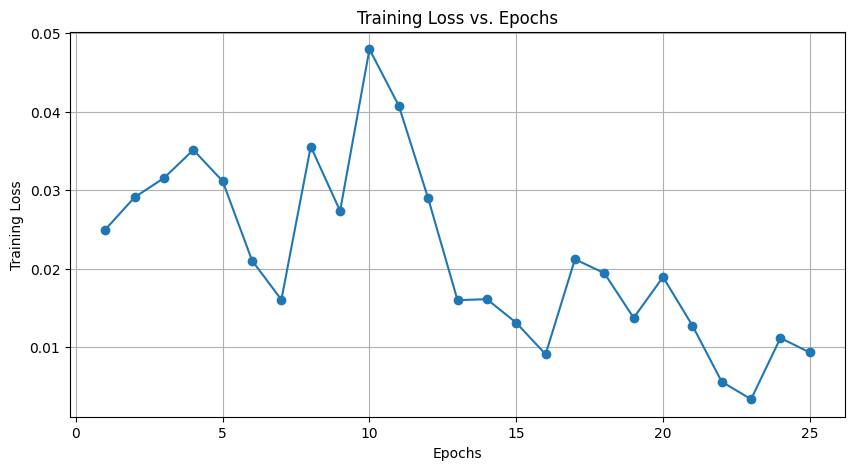

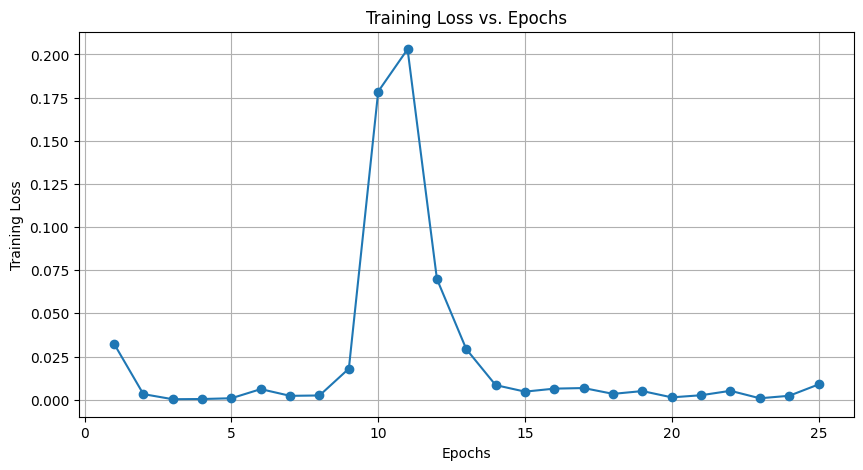


Federated Learning Round 26 for Model 3


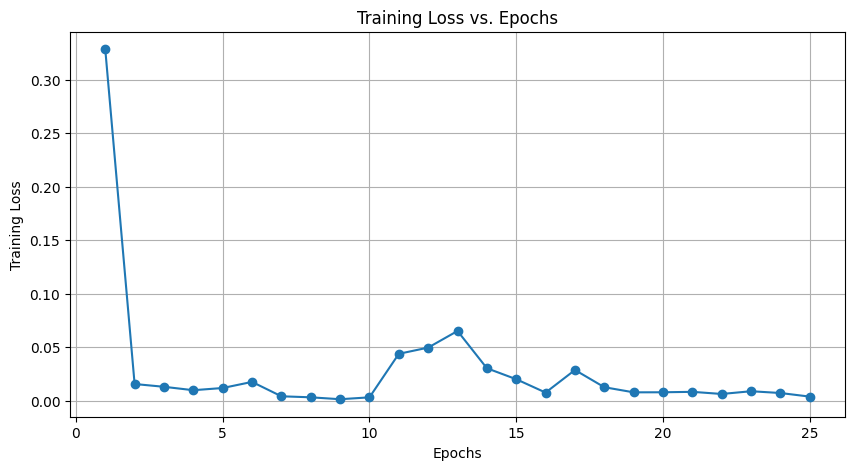

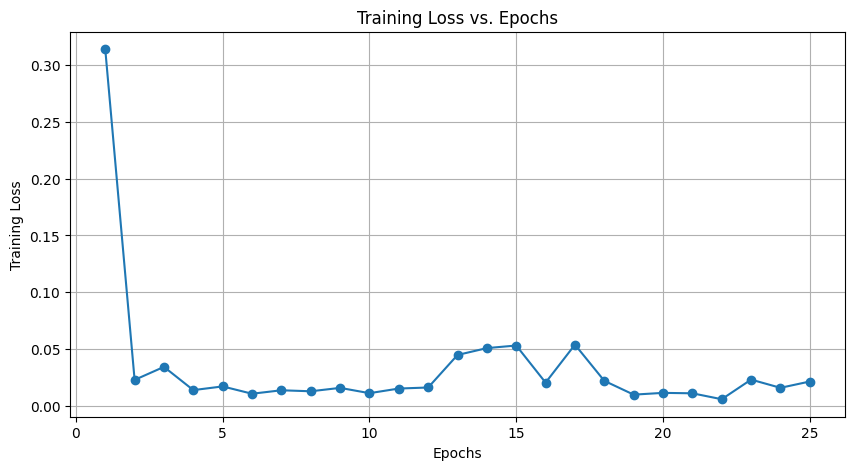

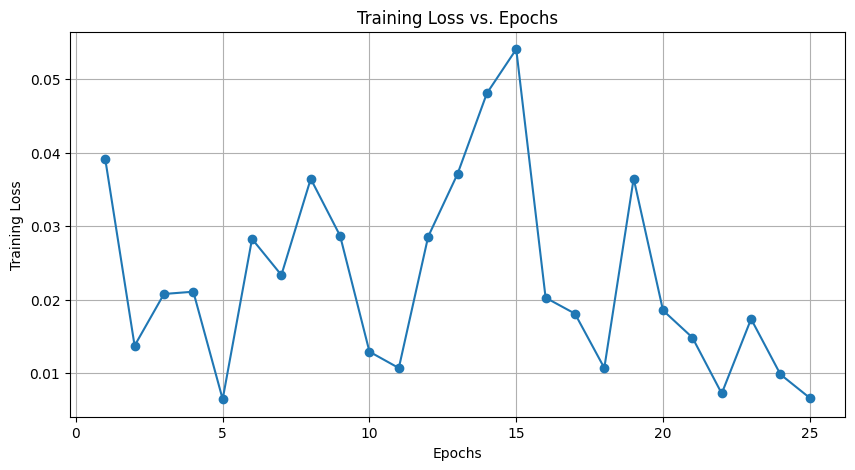


Federated Learning Round 27 for Model 3


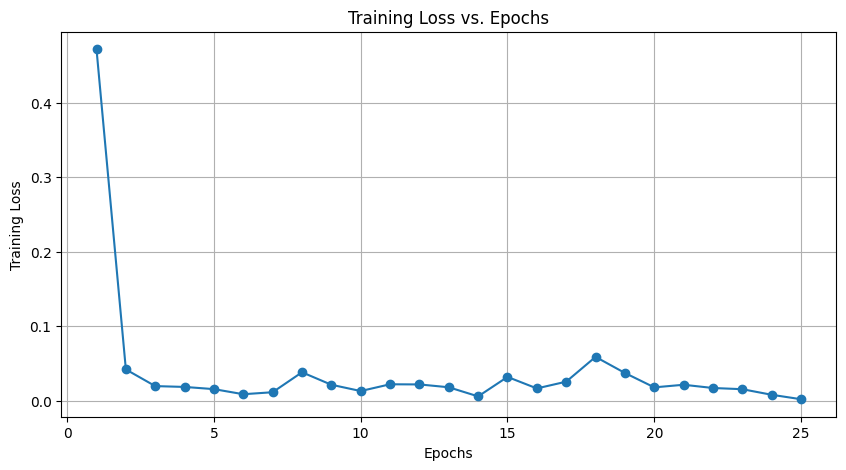

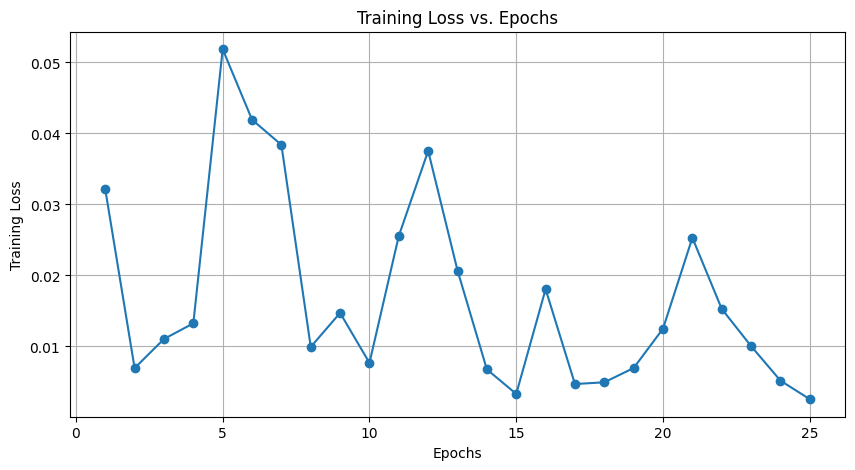

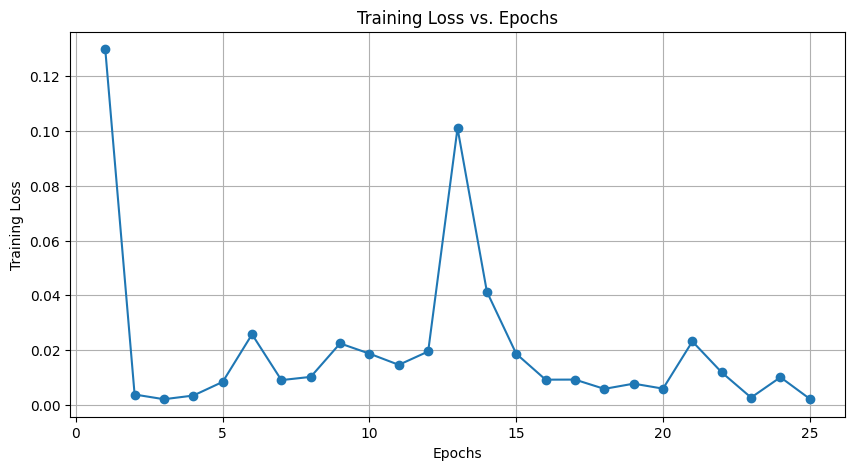


Federated Learning Round 28 for Model 3


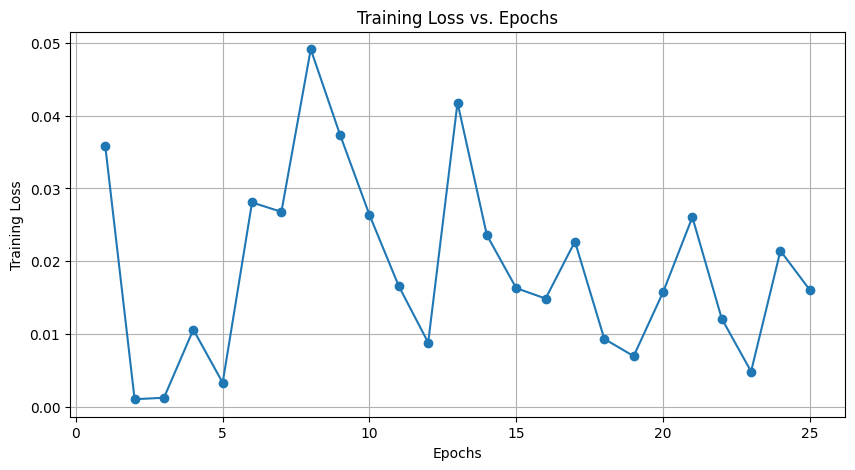

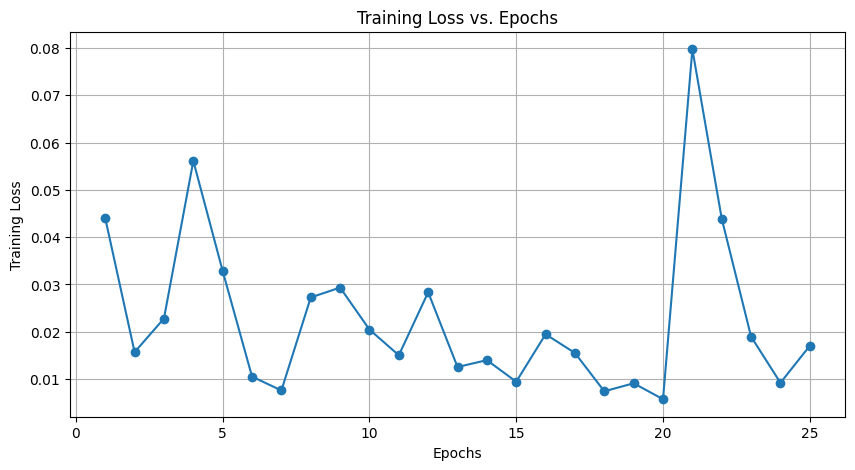

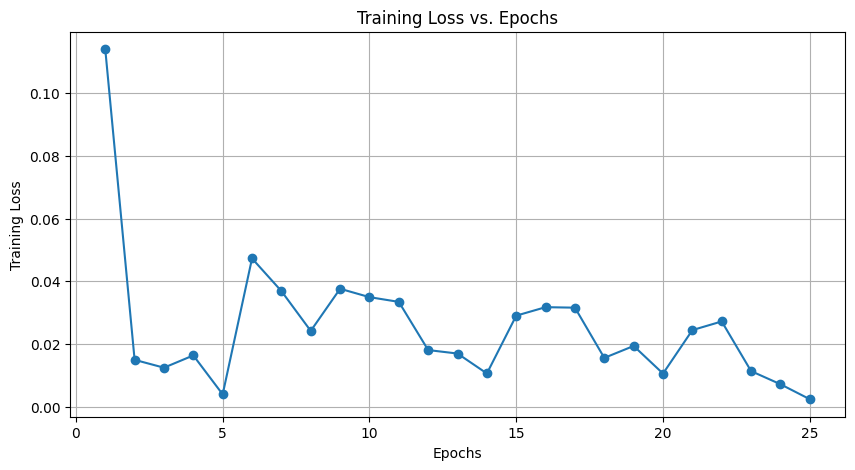


Federated Learning Round 29 for Model 3


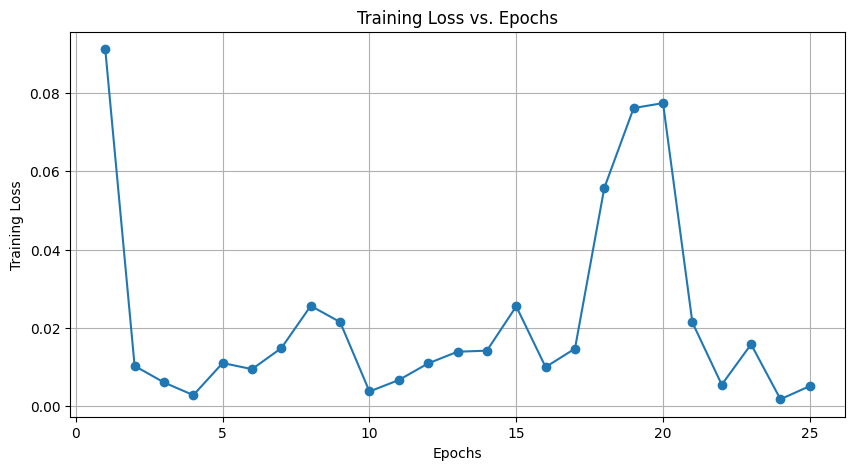

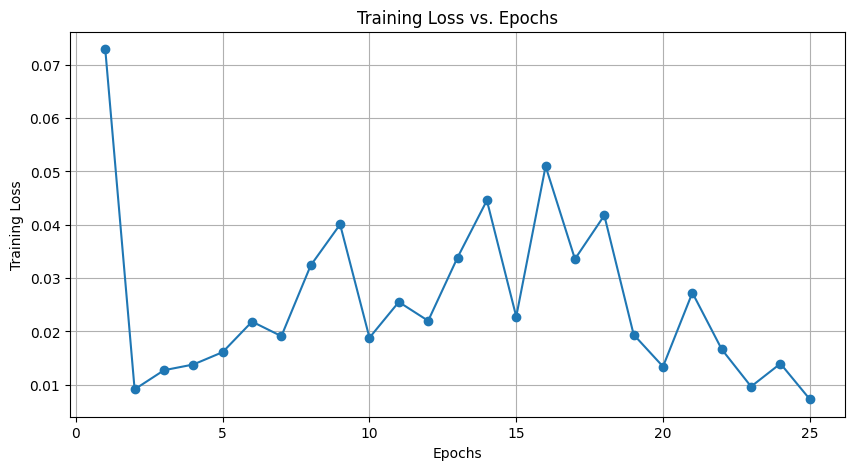

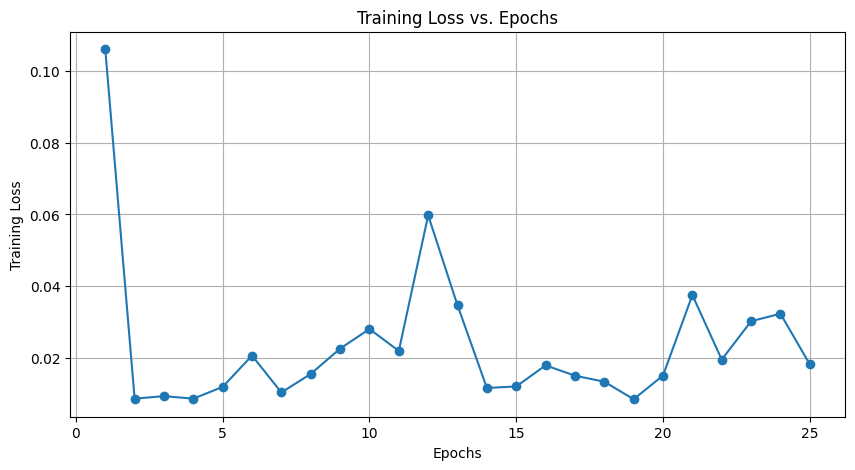


Federated Learning Round 30 for Model 3


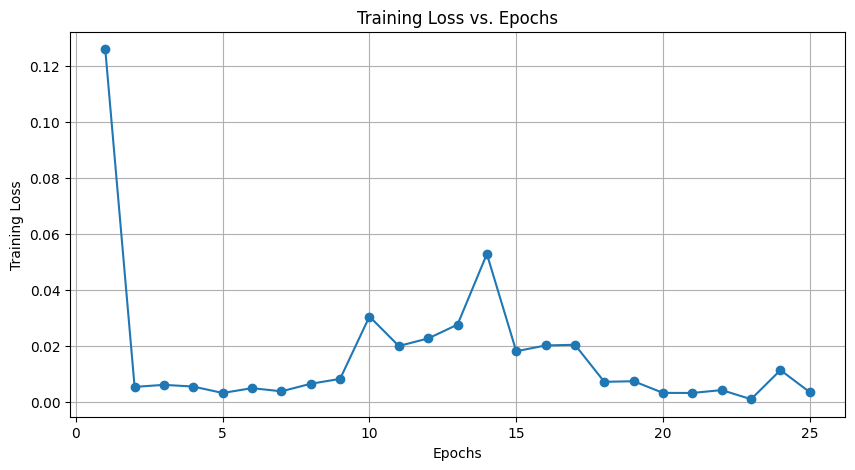

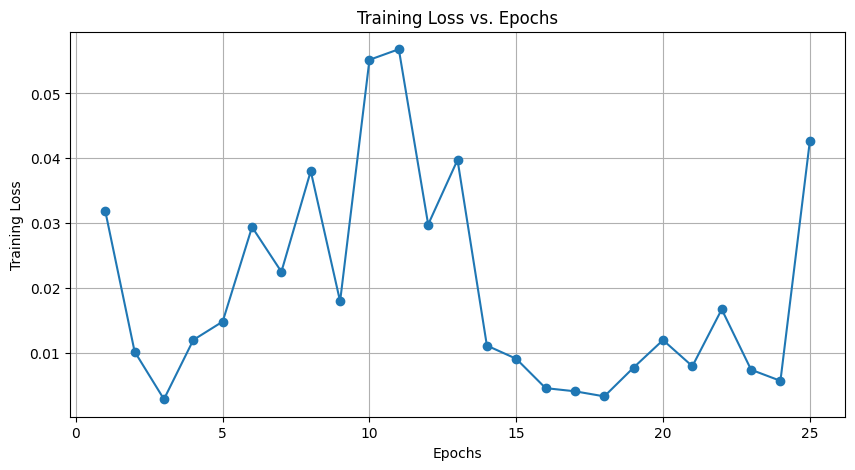

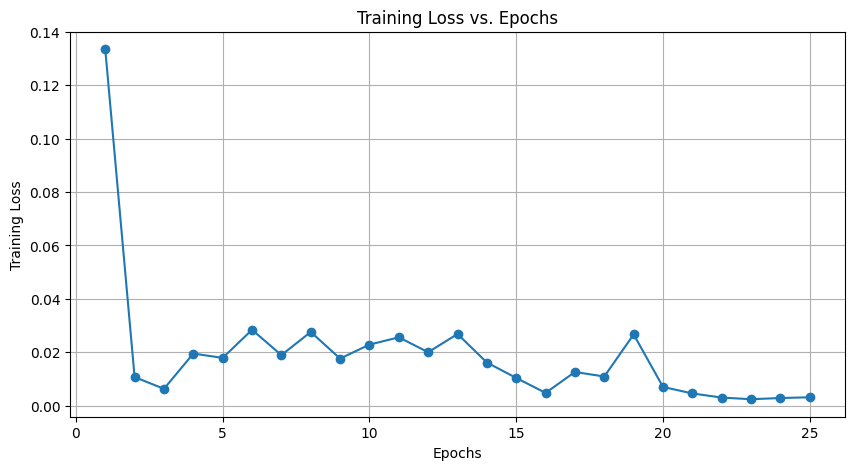


Federated Learning Round 31 for Model 3


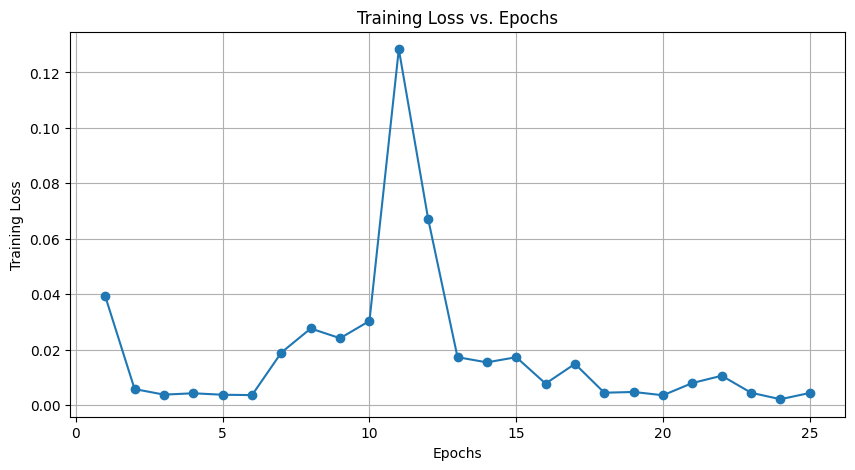

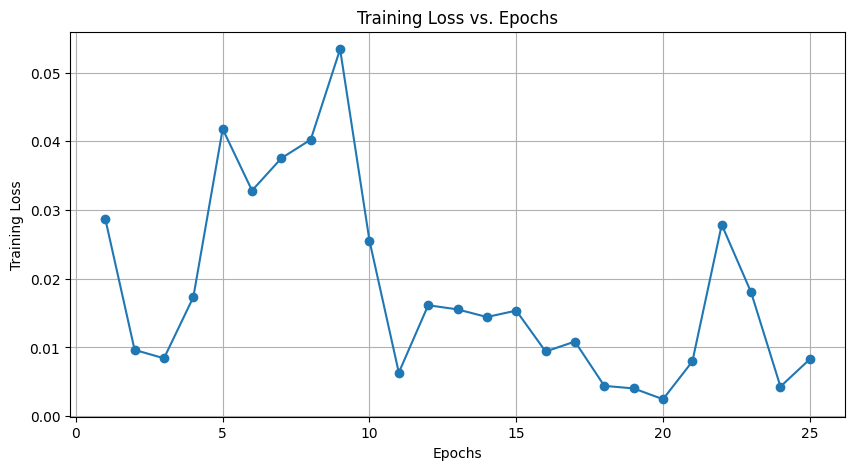

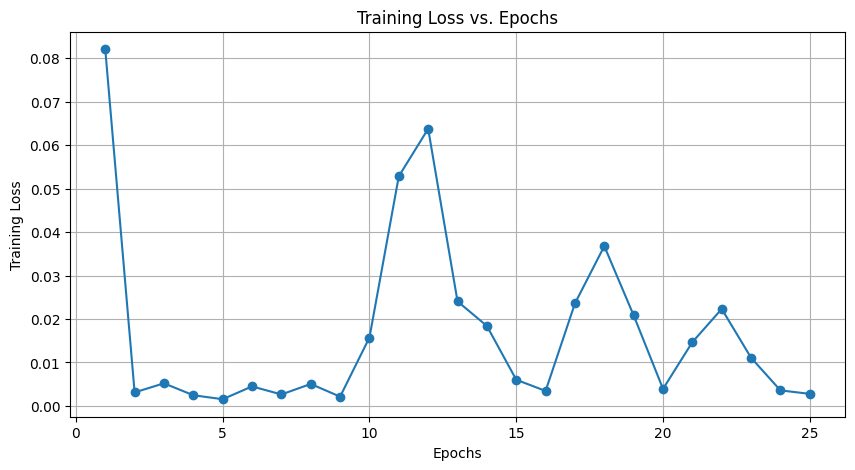


Federated Learning Round 32 for Model 3


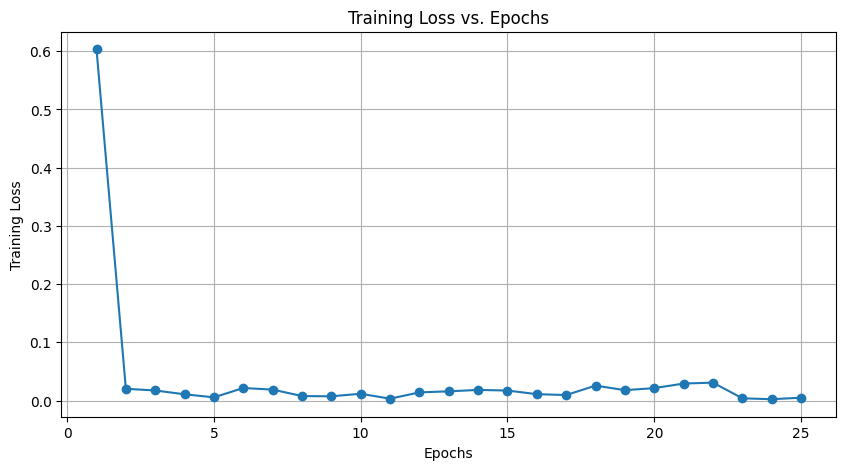

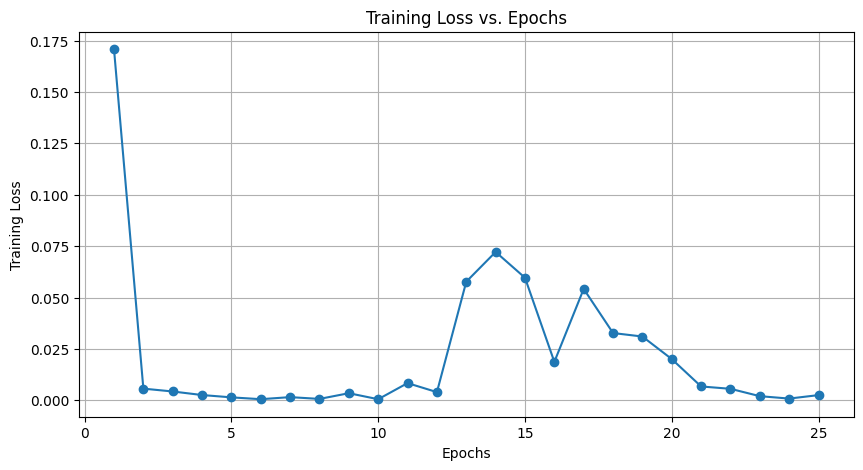

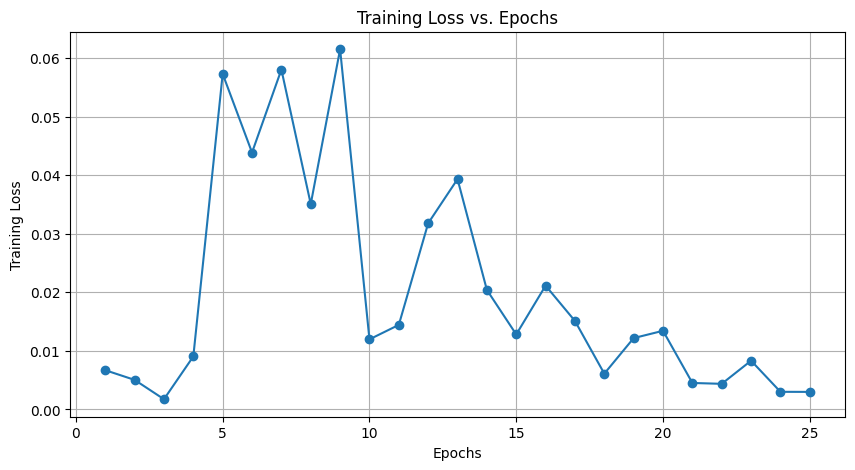


Federated Learning Round 33 for Model 3


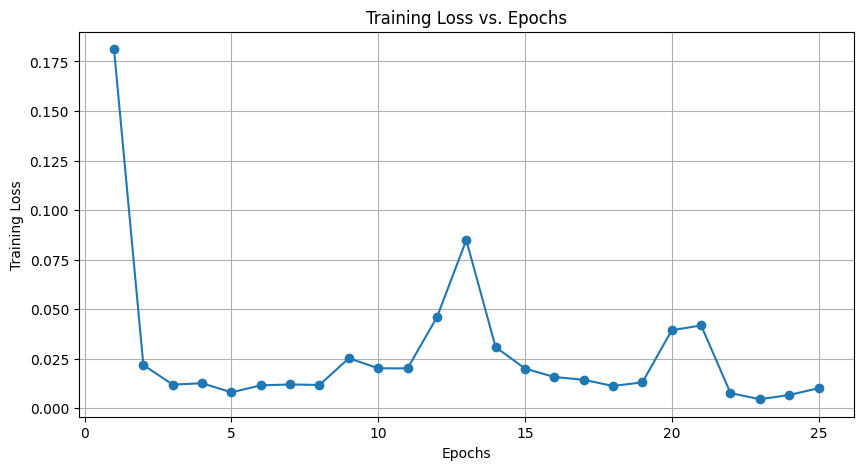

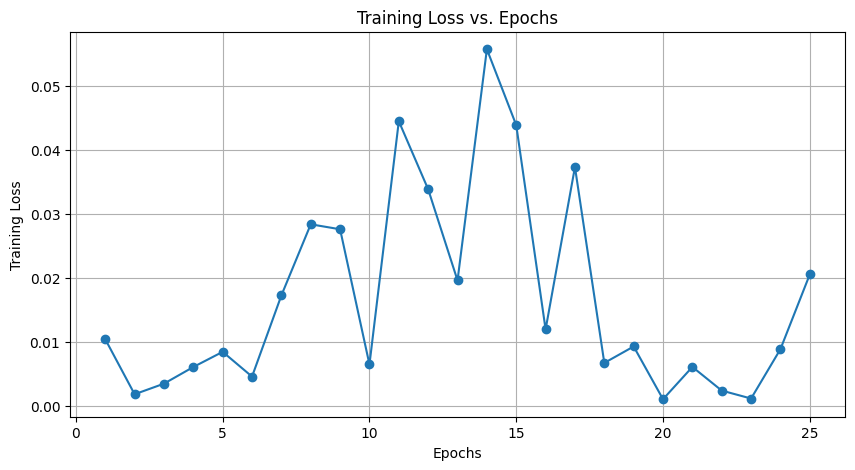

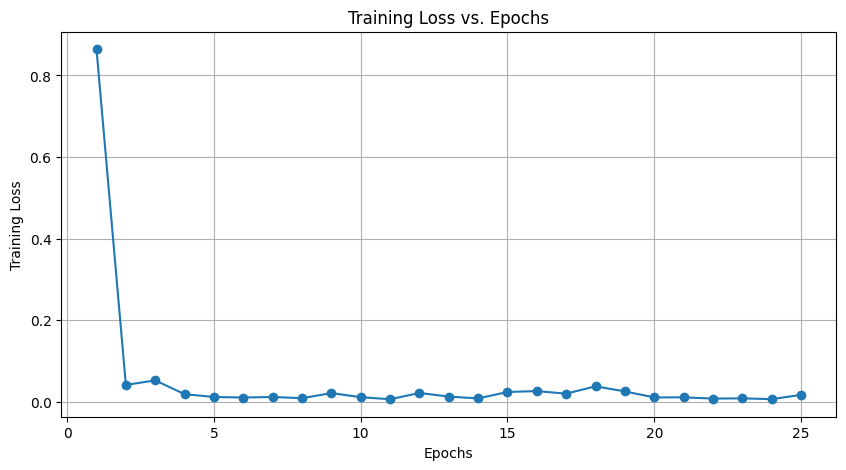


Federated Learning Round 34 for Model 3


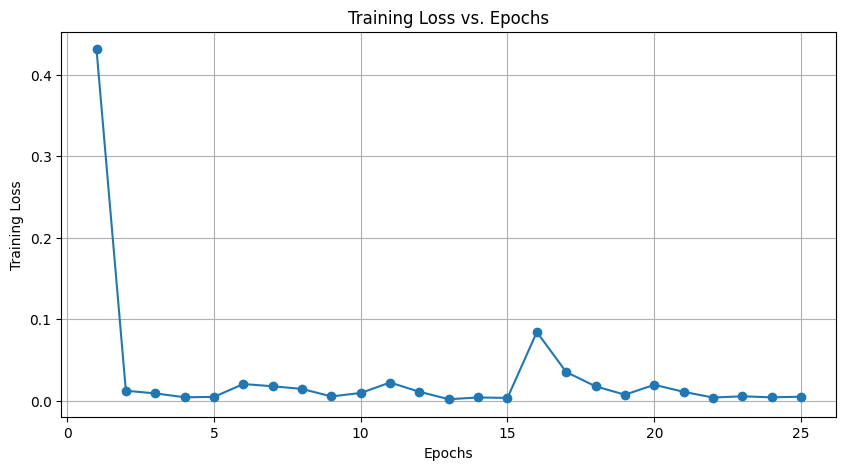

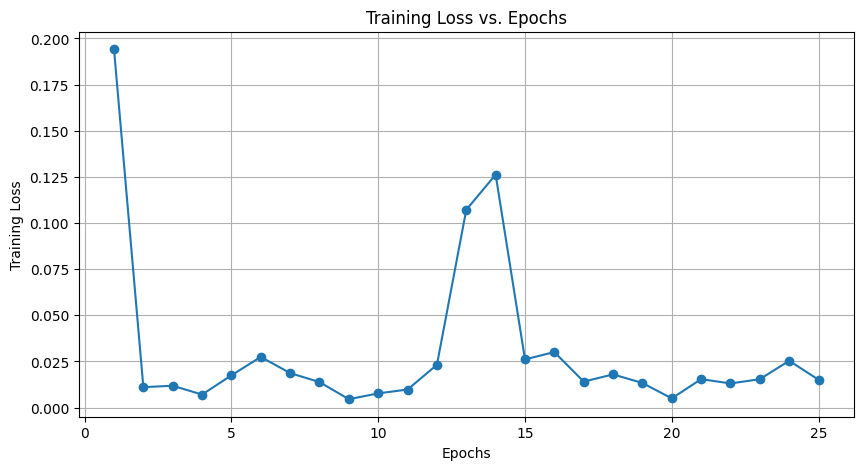

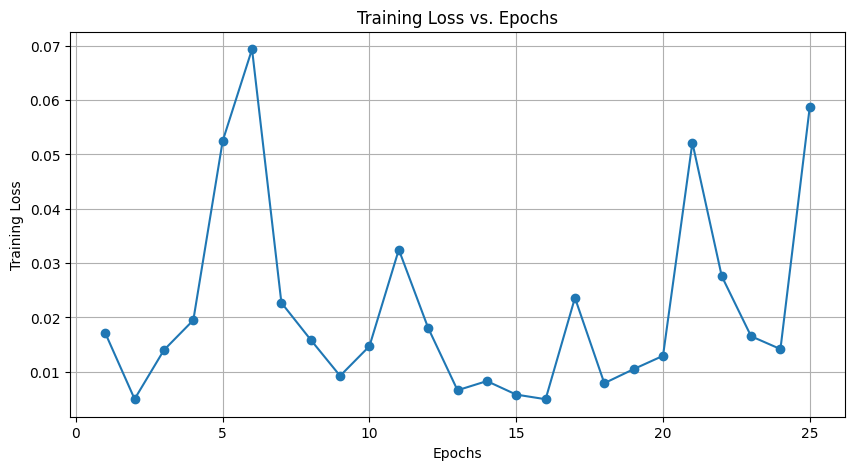


Federated Learning Round 35 for Model 3


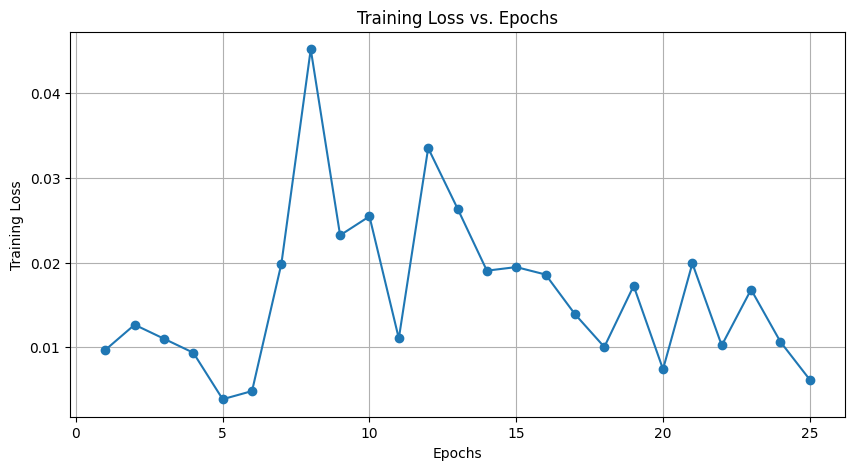

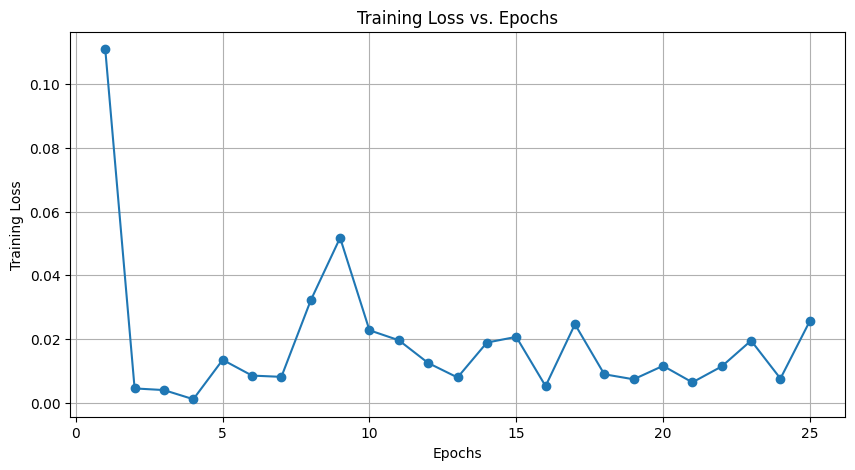

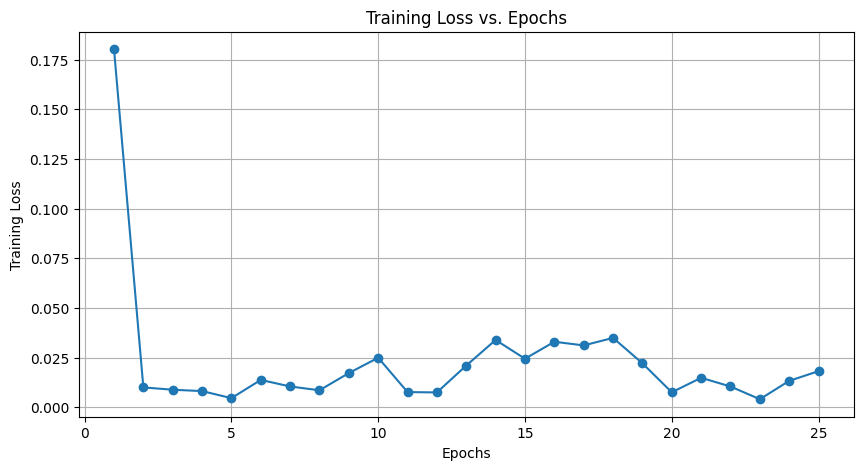


Federated Learning Round 36 for Model 3


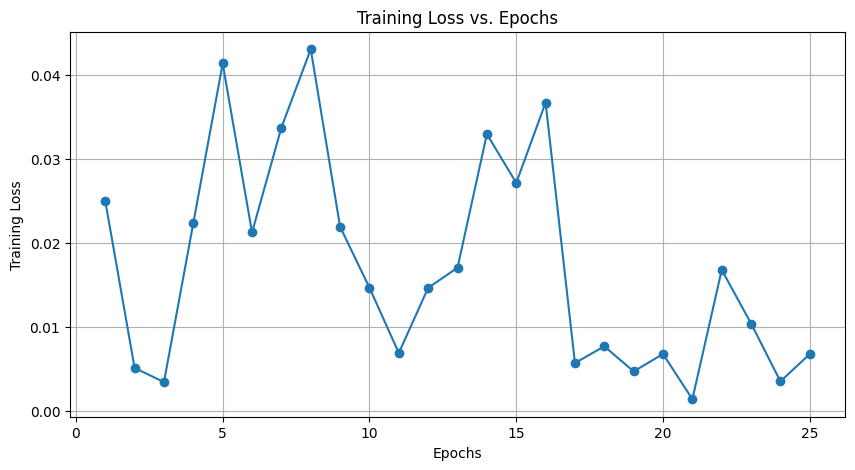

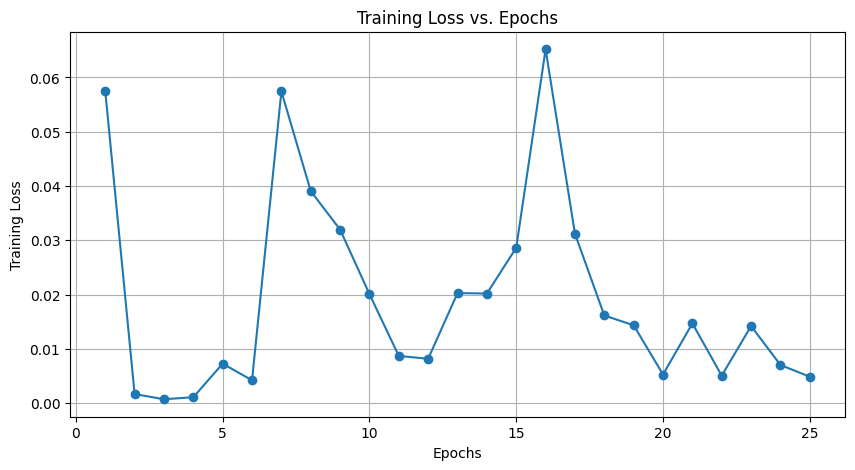

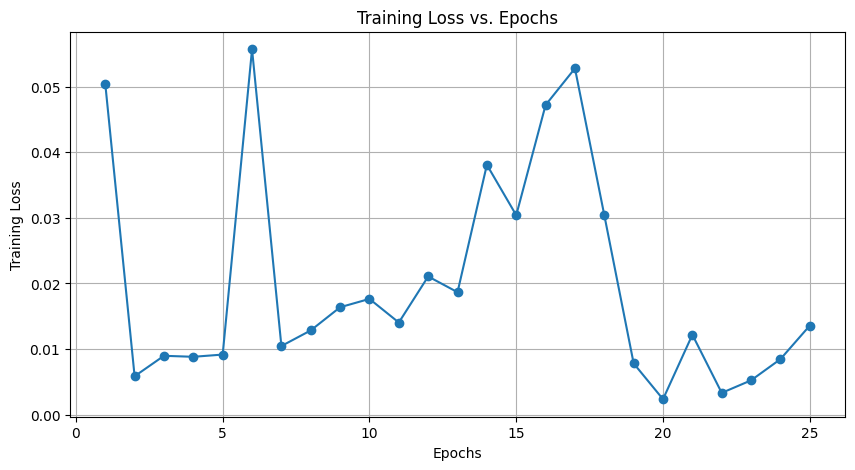


Federated Learning Round 37 for Model 3


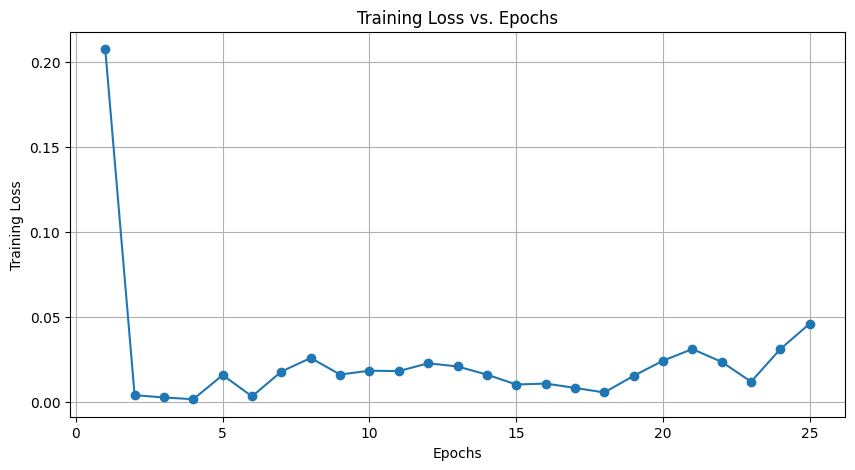

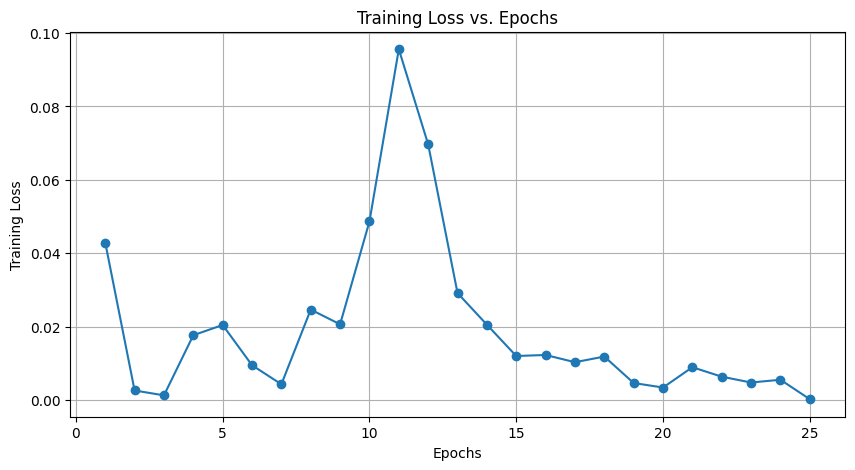

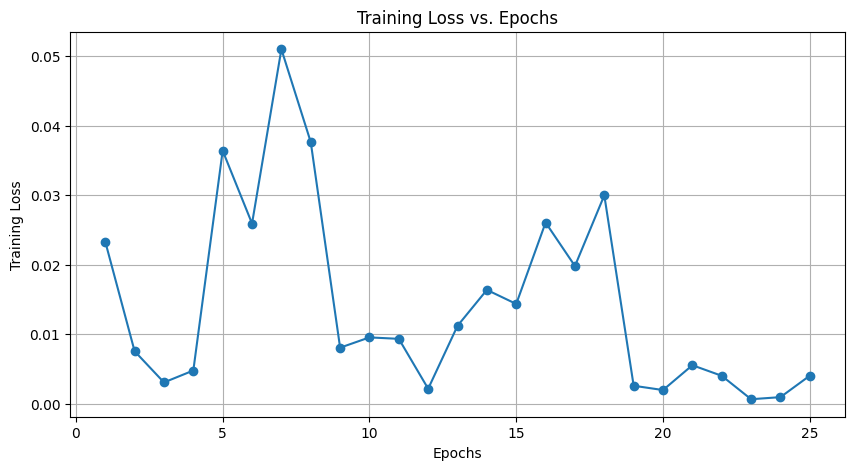


Federated Learning Round 38 for Model 3


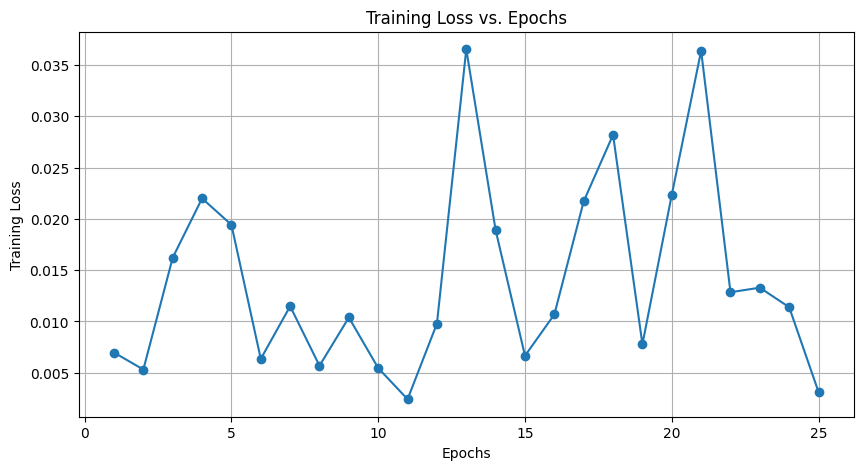

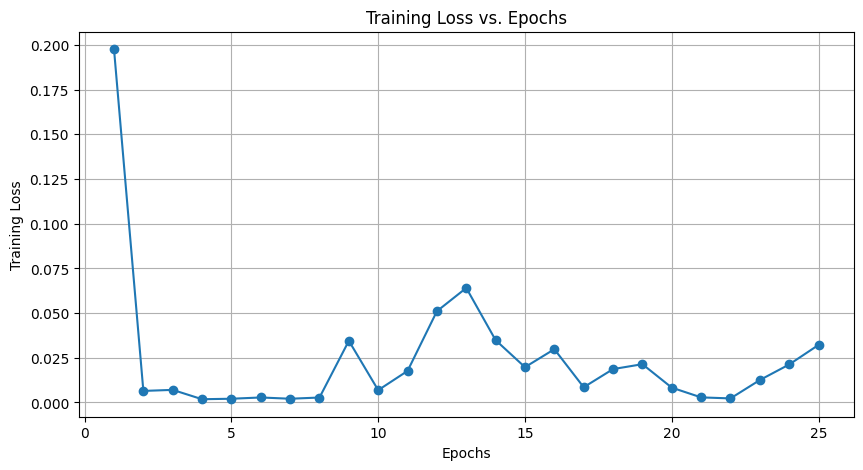

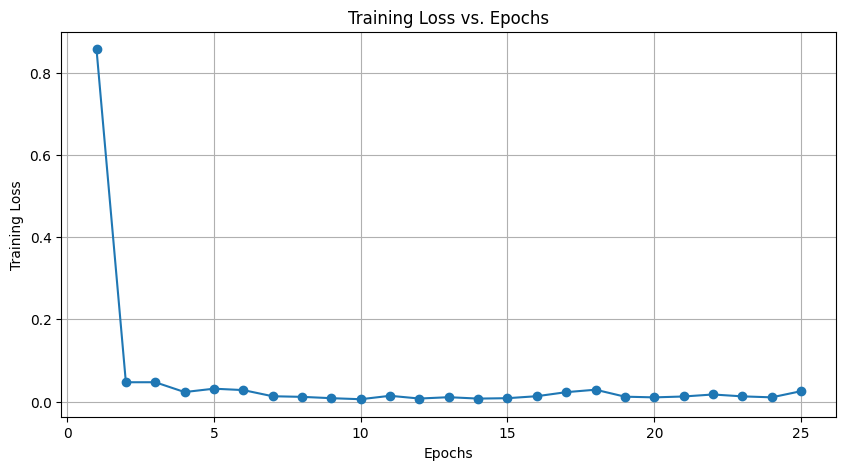


Federated Learning Round 39 for Model 3


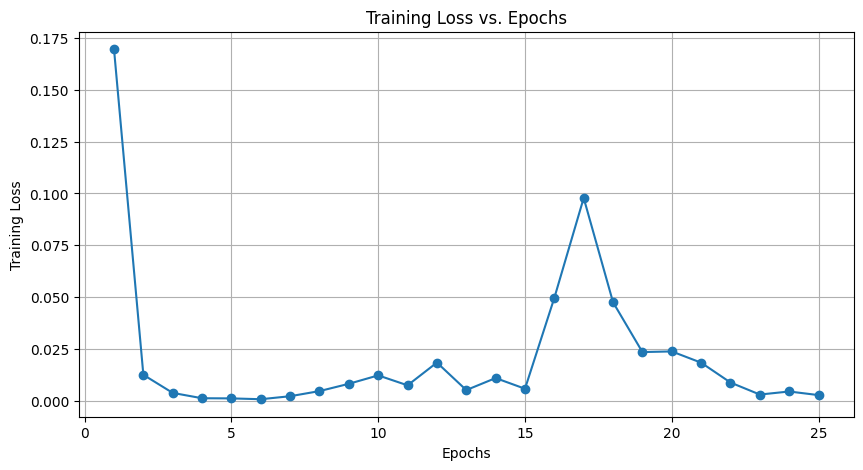

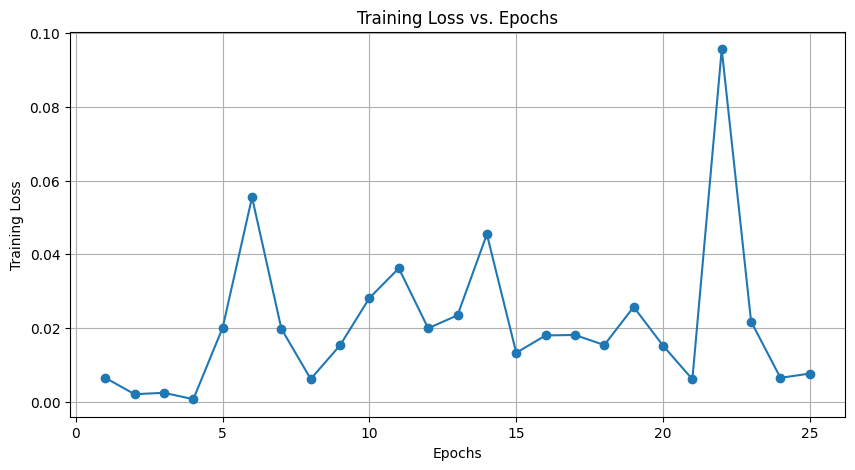

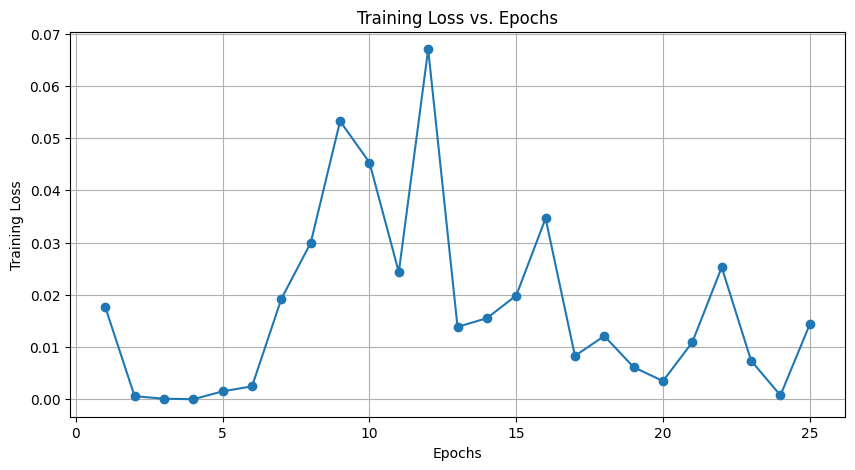


Federated Learning Round 40 for Model 3


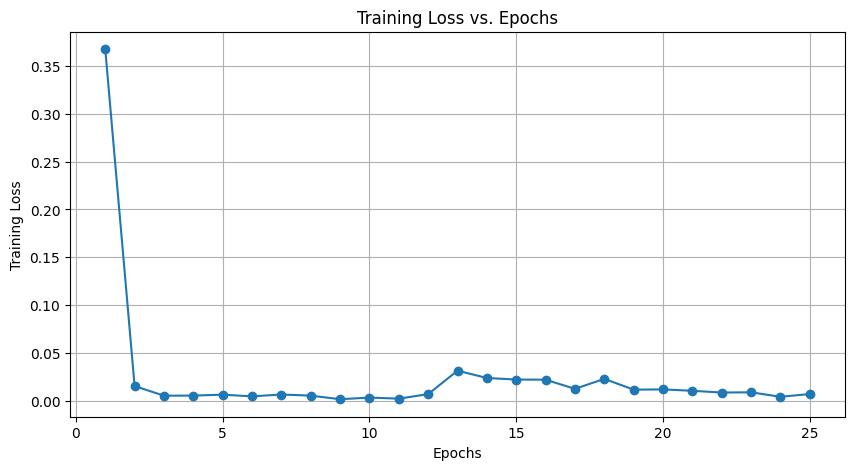

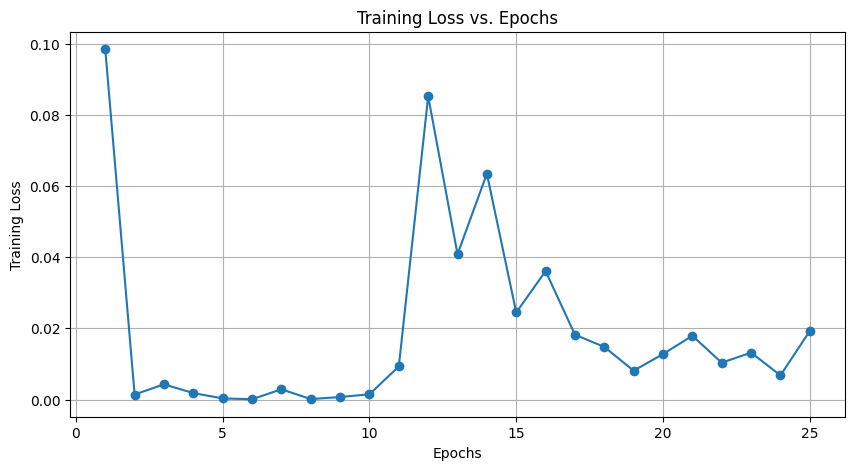

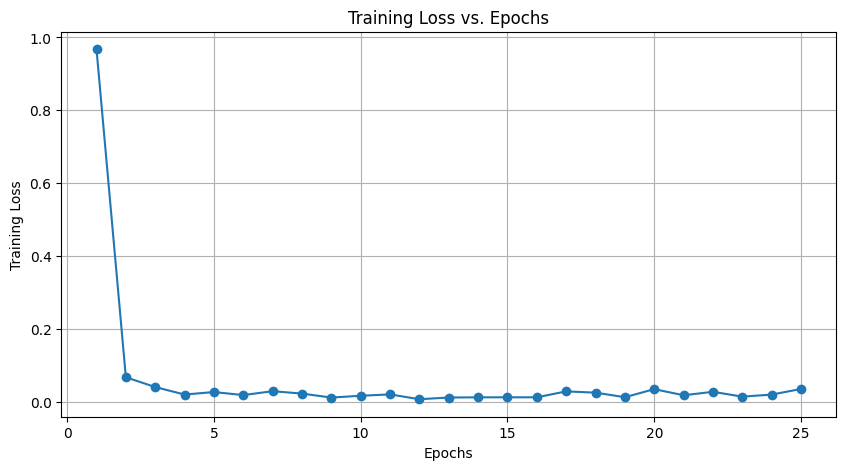

Testing Model 3 for Client 0...
Model 3 Test Loss: 1.0694, Test Accuracy: 75.75%
Testing Model 3 for Client 1...
Model 3 Test Loss: 1.1872, Test Accuracy: 74.74%
Testing Model 3 for Client 2...
Model 3 Test Loss: 1.2451, Test Accuracy: 75.23%
Testing Model 3 for Client 3...
Model 3 Test Loss: 1.3927, Test Accuracy: 75.16%
Testing Model 3 for Client 4...
Model 3 Test Loss: 0.6075, Test Accuracy: 86.93%


In [21]:
global_model3 = Model3().to(device)  # Updated Model3 for CIFAR input
num_rounds = 40

for round_num in range(num_rounds):
    print(f'\nFederated Learning Round {round_num + 1} for Model 3')

    # Randomly select 3 clients
    selected_clients = random.sample(range(len(client_data_list)), 3)

    # Prepare to collect trained models from clients
    client_models = []

    # Train Model 3 using selected clients' data
    for client_id in selected_clients:
        #print(f'Training Model 3 for Client {client_id}...')

        # Create a new instance of the model3 for this client
        model3 = Model3().to(device)  # Move to device
        model3.load_state_dict(global_model3.state_dict())  # Initialize from global model

        model3_train_loader = DataLoader(model3_datasets[client_id][0], batch_size=64, shuffle=True)
        optimizer3 = optim.Adam(model3.parameters(), lr=0.001)

        # Train the model on the client's data
        train_model(model3, model3_train_loader, criterion2, optimizer3,num_epochs=25)
        client_models.append(model3)

    # Average model parameters
    new_model_params = federated_average(client_models)

    # Update the global model parameters with the averaged parameters
    global_model3.load_state_dict(new_model_params)

# Test Model 3 after Federated Learning
for client_id in range(len(client_data_list)):
    print(f'Testing Model 3 for Client {client_id}...')
    model3_test_loader = DataLoader(model3_datasets[client_id][1], batch_size=32)

    # Move the global model to the device for testing
    test_loss3, test_accuracy3 = test_model(global_model3.to(device), model3_test_loader, criterion2)
    print(f'Model 3 Test Loss: {test_loss3:.4f}, Test Accuracy: {test_accuracy3:.2f}%')


In [22]:
from safetensors.torch import save_file
import json

# Saving model parameters and threshold for each client
for client_id, params in enumerate(client_model_parameters):
    # Save model parameters for each client model in safetensors format
    save_file(params['model1'], f'client_{client_id}_model1.safetensors')
    save_file(params['model2'], f'client_{client_id}_model2.safetensors')
    save_file(params['model4'], f'client_{client_id}_model4.safetensors')
    
    # Save threshold value for Model 1 in JSON format
    threshold_data = {'threshold1': params['threshold1'].item()}  # Assuming threshold1 is a tensor
    with open(f'client_{client_id}_threshold1.json', 'w') as json_file:
        json.dump(threshold_data, json_file)

# Save the global model parameters for Model 3 in safetensors format
save_file(global_model3.state_dict(), 'global_model3.safetensors')

print('Models and thresholds saved successfully.')


Models and thresholds saved successfully.


In [23]:
def determine_actual_label(true_label, client_private_labels):
    # Actual label is known if it's in range 0-4 or in client's private labels
    known_classes = set(range(5)).union(client_private_labels)
    return true_label if true_label in known_classes else -1

def determine_predicted_label(image, client_model_parameters, client_private_labels, model3, device):
    # Unpack models and thresholds
    model3.eval()
    model1 = Autoencoder().to(device)  # Move to device
    model2 = Model2().to(device)  # Move to device
    model4 = Model4().to(device)  # Move to device

    # Load state dicts into the models
    model1.load_state_dict(client_model_parameters['model1'])
    model2.load_state_dict(client_model_parameters['model2'])
    model4.load_state_dict(client_model_parameters['model4'])
    threshold1 = client_model_parameters['threshold1']

    # Move image to device
    image = image.to(device)

    # Model 1 (Autoencoder) check
    output1 = model1(image.unsqueeze(0))  # Add batch dimension for the image
    loss = nn.MSELoss(reduction='none')(output1, image.unsqueeze(0))  # Compute MSE loss
    loss = loss.mean([1, 2, 3])  # Average over each image to get a per-image loss

    # Determine predictions based on reconstruction loss
    predictions = (loss < threshold1).long()  # Anomalies have higher loss, flagged as unknown

    # If reconstruction loss is high, return unknown
    if predictions.item() == 0:  # If prediction is 0 (unknown)
        return -1

    # Model 2 classification
    output2 = model2(image.unsqueeze(0))
    pred2 = torch.argmax(output2, dim=1).item()

    # If Model 2 predicts common classes (0)
    if pred2 == 0:
        output3 = model3(image.unsqueeze(0).to(device))  # Ensure model3 input is on device
        return torch.argmax(output3, dim=1).item()

    # If Model 2 predicts private classes (1)
    elif pred2 == 1:
        output4 = model4(image.unsqueeze(0))  # Already on device
        private_class_index = torch.argmax(output4, dim=1).item()

        private_labels = client_private_labels  # List of private labels passed as argument
        if private_class_index < len(private_labels):
            return private_labels[private_class_index]  # Return the actual private label


Files already downloaded and verified
Total Samples: 500
Label Counts and Incorrect Predictions:
Label 0: 48 actual, 9 incorrect predictions
Label 1: 44 actual, 4 incorrect predictions
Label 2: 58 actual, 23 incorrect predictions
Label 3: 57 actual, 26 incorrect predictions
Label 4: 48 actual, 10 incorrect predictions
Label 5: 67 actual, 40 incorrect predictions
Label 6: 47 actual, 37 incorrect predictions
Label -1: 131 actual, 127 incorrect predictions


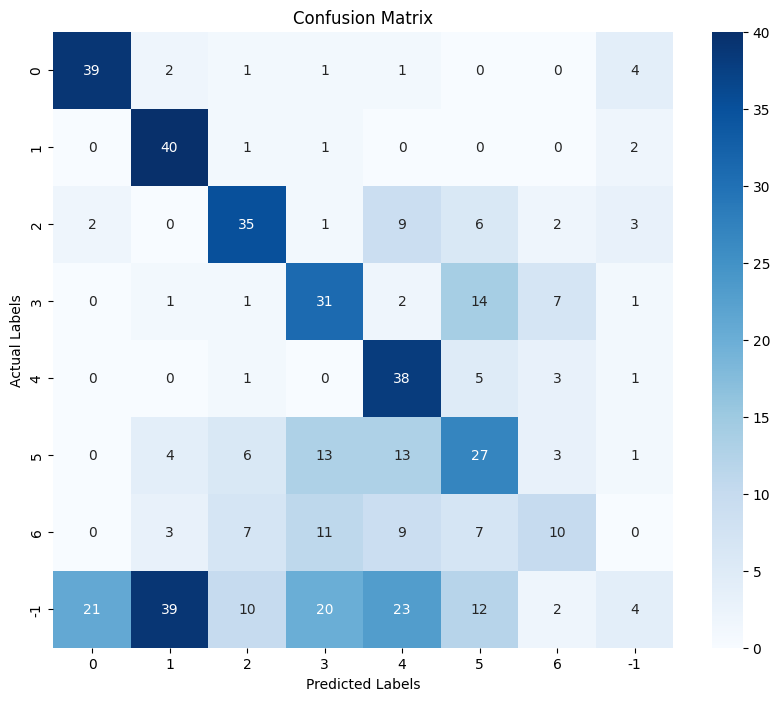

Client 1 Accuracy: 44.80%
Files already downloaded and verified
Total Samples: 500
Label Counts and Incorrect Predictions:
Label 0: 56 actual, 35 incorrect predictions
Label 1: 45 actual, 8 incorrect predictions
Label 2: 47 actual, 22 incorrect predictions
Label 3: 46 actual, 10 incorrect predictions
Label 4: 59 actual, 22 incorrect predictions
Label 7: 46 actual, 8 incorrect predictions
Label 8: 45 actual, 10 incorrect predictions
Label -1: 156 actual, 148 incorrect predictions


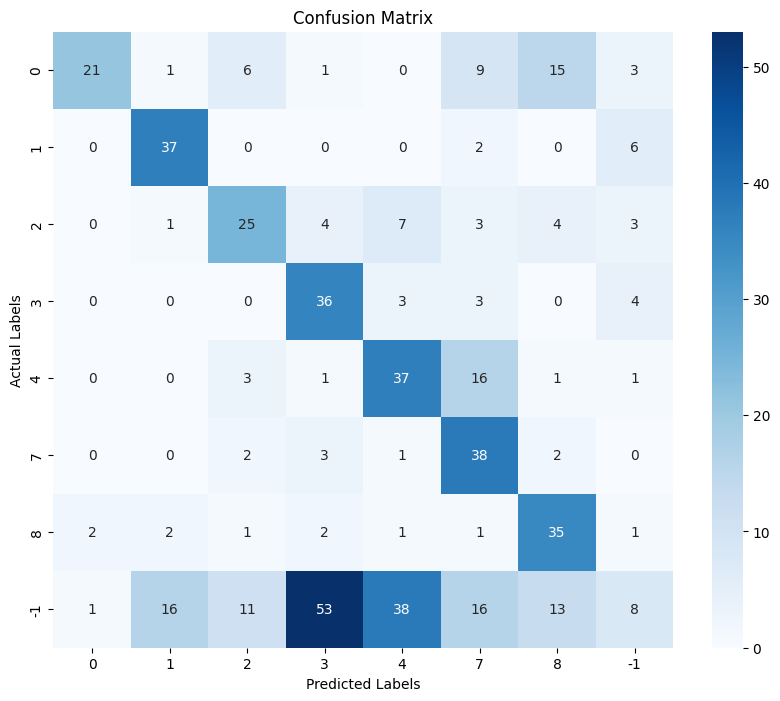

Client 2 Accuracy: 47.40%
Files already downloaded and verified
Total Samples: 500
Label Counts and Incorrect Predictions:
Label 0: 54 actual, 28 incorrect predictions
Label 1: 45 actual, 38 incorrect predictions
Label 2: 59 actual, 24 incorrect predictions
Label 3: 45 actual, 9 incorrect predictions
Label 4: 49 actual, 8 incorrect predictions
Label 6: 51 actual, 32 incorrect predictions
Label 9: 47 actual, 8 incorrect predictions
Label -1: 150 actual, 141 incorrect predictions


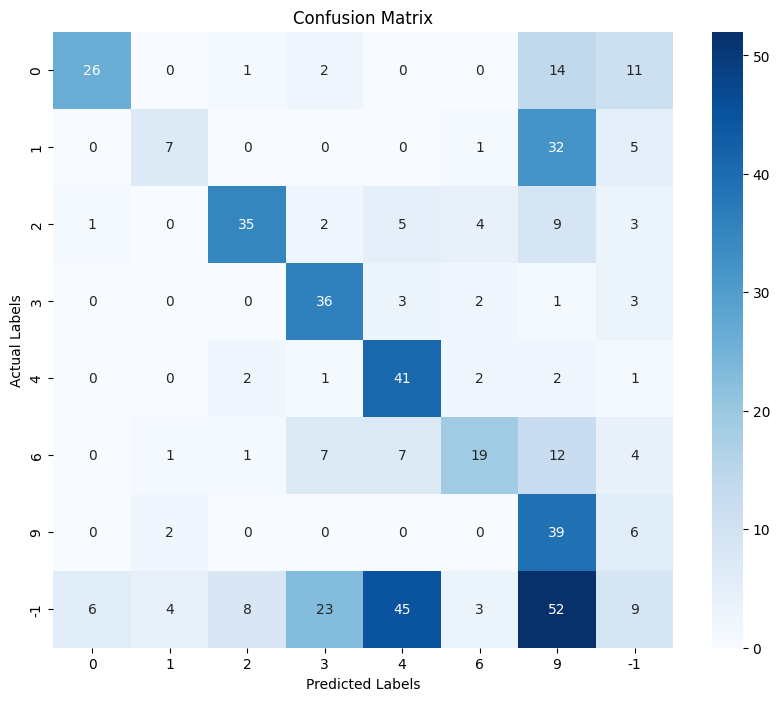

Client 3 Accuracy: 42.40%
Files already downloaded and verified
Total Samples: 500
Label Counts and Incorrect Predictions:
Label 0: 56 actual, 16 incorrect predictions
Label 1: 55 actual, 43 incorrect predictions
Label 2: 71 actual, 50 incorrect predictions
Label 3: 40 actual, 20 incorrect predictions
Label 4: 41 actual, 8 incorrect predictions
Label 5: 40 actual, 7 incorrect predictions
Label 9: 42 actual, 9 incorrect predictions
Label -1: 155 actual, 146 incorrect predictions


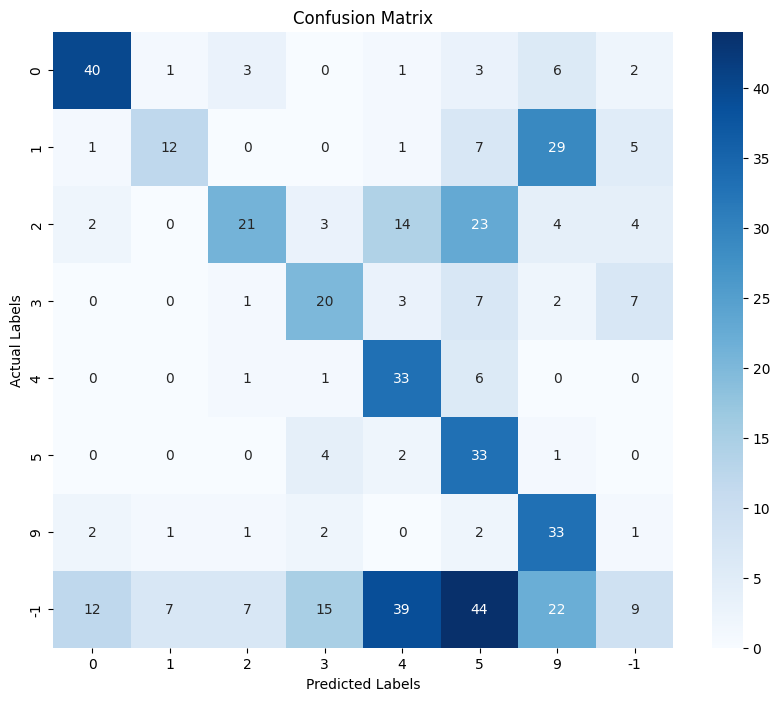

Client 4 Accuracy: 40.20%
Files already downloaded and verified
Total Samples: 500
Label Counts and Incorrect Predictions:
Label 0: 49 actual, 18 incorrect predictions
Label 1: 56 actual, 20 incorrect predictions
Label 2: 47 actual, 34 incorrect predictions
Label 3: 49 actual, 30 incorrect predictions
Label 4: 44 actual, 28 incorrect predictions
Label 7: 68 actual, 11 incorrect predictions
Label 8: 38 actual, 5 incorrect predictions
Label -1: 149 actual, 146 incorrect predictions


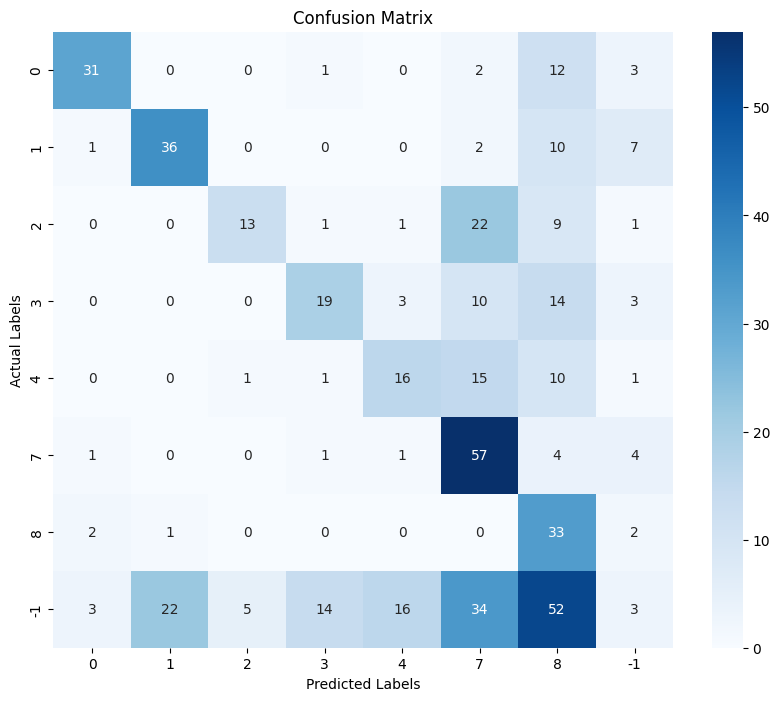

Client 5 Accuracy: 41.60%


In [24]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# Define function to load random samples
def load_random_samples(batch_size=500, device=None):
    # Load CIFAR-10 dataset
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

    # Randomly select 500 samples
    random_indices = random.sample(range(len(dataset)), batch_size)
    random_subset = Subset(dataset, random_indices)

    return DataLoader(random_subset, batch_size=batch_size)

# Function to evaluate model accuracy and plot images

def evaluate_model_accuracy_and_plot(client_model_parameters, client_private_labels, model3, device):
    data_loader = load_random_samples(device=device)
    
    total_samples = 0
    correct_predictions = 0

    # Initialize dictionaries to count incorrect predictions for each label
    incorrect_counts = {label: 0 for label in range(5)}  # For labels 0-4
    for label in client_private_labels:
        incorrect_counts[label] = 0  # Include private labels
    incorrect_counts[-1] = 0  # For unknown label -1

    # Initialize dictionary to count actual occurrences of each label
    actual_counts = {label: 0 for label in range(5)}  # For labels 0-4
    for label in client_private_labels:
        actual_counts[label] = 0  # Include private labels
    actual_counts[-1] = 0  # For unknown label -1

    # Lists to collect all actual and predicted labels for confusion matrix
    all_actual_labels = []
    all_predicted_labels = []

    for images, true_labels in data_loader:
        images = images.to(device)  # Move images to device
        true_labels = true_labels.to(device)  # Move labels to device
        
        for image, true_label in zip(images, true_labels):
            actual_label = determine_actual_label(true_label.item(), client_private_labels)
            predicted_label = determine_predicted_label(image, client_model_parameters, client_private_labels, model3, device)

            total_samples += 1
            
            # Count actual occurrences of the label
            if actual_label in actual_counts:
                actual_counts[actual_label] += 1

            if predicted_label == actual_label:
                correct_predictions += 1
            else:
                # Count incorrect predictions for the actual label
                if actual_label in incorrect_counts:
                    incorrect_counts[actual_label] += 1

            # Collect labels for confusion matrix
            all_actual_labels.append(actual_label)
            all_predicted_labels.append(predicted_label)

    accuracy = correct_predictions / total_samples if total_samples > 0 else 0
    print(f'Total Samples: {total_samples}')
    #print(f'Accuracy: {accuracy * 100:.2f}%')
    
    # Print the counts of actual occurrences and incorrect predictions for each label
    print('Label Counts and Incorrect Predictions:')
    for label in actual_counts.keys():
        print(f'Label {label}: {actual_counts[label]} actual, {incorrect_counts[label]} incorrect predictions')

    # Plot confusion matrix
    plot_confusion_matrix(all_actual_labels, all_predicted_labels, client_private_labels)

    return accuracy

def plot_confusion_matrix(actual_labels, predicted_labels, private_labels):
    # Generate all labels (common labels 0-4, private labels, and -1 for unknown)
    all_labels = list(range(5)) + private_labels + [-1]
    
    # Compute confusion matrix
    cm = confusion_matrix(actual_labels, predicted_labels, labels=all_labels)
    
    # Plot using seaborn for a heatmap style
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=all_labels, yticklabels=all_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate and plot for each client
for i in range(5):
    accuracy = evaluate_model_accuracy_and_plot(client_model_parameters[i], client_private_labels[i], global_model3, device)
    print(f'Client {i + 1} Accuracy: {accuracy * 100:.2f}%')


In [25]:
from safetensors.torch import load_file
import json

# Define the number of clients (should match your initial number)
num_clients = <num_clients>  # Replace <num_clients> with the actual number

# Loading model parameters and thresholds for each client
for client_id in range(num_clients):
    # Load model parameters for each client model from safetensors
    model1_params = load_file(f'client_{client_id}_model1.safetensors')
    model2_params = load_file(f'client_{client_id}_model2.safetensors')
    model4_params = load_file(f'client_{client_id}_model4.safetensors')
    
    # Reinitialize your model objects and load state_dict if needed
    # Example:
    # model1.load_state_dict(model1_params)

    # Load threshold value for Model 1 from JSON
    with open(f'client_{client_id}_threshold1.json', 'r') as json_file:
        threshold_data = json.load(json_file)
        threshold1 = threshold_data['threshold1']  # Use as needed

# Load the global model parameters for Model 3 from safetensors
global_model3_params = load_file('global_model3.safetensors')

# Reinitialize the global model and load the state_dict if needed
# Example:
# global_model3.load_state_dict(global_model3_params)

print('Models and thresholds loaded successfully.')


SyntaxError: invalid syntax (2556704949.py, line 5)